#Pytorch Adapter Network Tester MNIST Reduced

##Revision History and Current Todo

# USYD Code Citation

Nicholas Manning - 490297975

I acknowledge that the inspiration for the 1x1 adapter was from Sylvestre Rebuffi and Hakan Bilen's residual adapter code hosted here: https://github.com/srebuffi/residual_adapters and that I was inspired by their code.

I acknowledge that the basic network was built off the tutorial by Nutan at https://medium.com/@nutanbhogendrasharma/pytorch-convolutional-neural-network-with-mnist-dataset-4e8a4265e118

I also acknowledge that I built the weight freezing logic off work by chenyuntc on https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

I acknowledge that I was inspired by and solved a number of problems due to the posts of ptrblck - @ptrblck_de - Nvidia Engineer on https://discuss.pytorch.org https://discuss.pytorch.org/u/ptrblck/summary .

I further acknowledge that I was inspired by other tutorials, forum posts and general learning materials for many small details of my code, including the way I approached printing the parameters, creating a subset from the data and debugging my work.

##Setup

In [ ]:
downloadFilesGlobal = False

import torch
from torch import optim

from torchvision import datasets
import torchvision.datasets as datasets

from torchvision.transforms import ToTensor
from torchvision.transforms import v2

from torch.utils.data import DataLoader
from torch.utils.data import Subset

import torch.nn as nn

from torch.autograd import Variable

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np

import copy

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

#Datasets

##MNIST_reduced

###Import

In [ ]:
train_data_MNIST = datasets.MNIST(
    root = 'data_for_MNIST1to9',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data_MNIST = datasets.MNIST(
    root = 'data_for_MNIST1to9',
    train = False,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 64683908.01it/s]


Extracting data_for_MNIST1to9/MNIST/raw/train-images-idx3-ubyte.gz to data_for_MNIST1to9/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 64262967.55it/s]


Extracting data_for_MNIST1to9/MNIST/raw/train-labels-idx1-ubyte.gz to data_for_MNIST1to9/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 21704881.15it/s]


Extracting data_for_MNIST1to9/MNIST/raw/t10k-images-idx3-ubyte.gz to data_for_MNIST1to9/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13463271.21it/s]

Extracting data_for_MNIST1to9/MNIST/raw/t10k-labels-idx1-ubyte.gz to data_for_MNIST1to9/MNIST/raw



###Remove class

In [ ]:
# MNIST Get all targets
ds = train_data_MNIST
ds_test = test_data_MNIST

print("MNIST Train:\n\n",ds.data.shape, "MNIST Train Targets: ",ds.targets.shape)
print("\nMNIST Train Targets\n\n ",ds.targets.unique(return_counts=True))
print("\nTotal size - class size\n\n", ds.targets.shape[0]-ds.targets.unique(return_counts=True)[1])
print(ds.classes,"\n\n")

print("MNIST Test\n",ds_test.data.shape, "MNIST Test Targets: ",ds_test.targets.shape)
print("\nMNIST Test Targets\n",ds_test.targets.unique(return_counts=True))
print("\nTotal size - class size\n", ds_test.targets.shape[0]-ds_test.targets.unique(return_counts=True)[1])
print(ds_test.classes)

targets = ds.targets
targets_test = ds_test.targets

print(targets)
print(targets_test)

train_idx = np.arange(len(targets))
test_idx = np.arange(len(targets_test))

idx1 = targets[train_idx]!=0
idx1_test = targets_test[test_idx]!=0

print("\n\nIdx1 (#false is #class_to_remove)\n\n", idx1.unique(return_counts=True))
print("\nIdx1_test (#false is #class_to_remove)\n\n", idx1_test.unique(return_counts=True))

# Only keep your desired classes
train_idx = train_idx[idx1]
test_idx = test_idx[idx1_test]
print("\nConfirm count:\n\nTrain idx Shape:", train_idx.shape, "\nMatched size? ", train_idx.shape[0] == idx1.unique(return_counts=True)[1][1].item())
print("\nTest idx Shape:", test_idx.shape, "\nMatched size? ", test_idx.shape[0] == idx1_test.unique(return_counts=True)[1][1].item())


MNIST Train:

 torch.Size([60000, 28, 28]) MNIST Train Targets:  torch.Size([60000])

MNIST Train Targets

  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

Total size - class size

 tensor([54077, 53258, 54042, 53869, 54158, 54579, 54082, 53735, 54149, 54051])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine'] 


MNIST Test
 torch.Size([10000, 28, 28]) MNIST Test Targets:  torch.Size([10000])

MNIST Test Targets
 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

Total size - class size
 tensor([9020, 8865, 8968, 8990, 9018, 9108, 9042, 8972, 9026, 8991])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']
tensor([5, 0, 4,  ..., 5, 6, 8])
tensor([7, 2, 1,  ..., 4, 5, 6])


Idx1 (#false is #class_to_remove)

 (tensor([False,  

###Show Data

MNIST 1to9 Train

Shift classes by -1 (For N classes, train() needs classes 0..N-1)

(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])) 10
(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])) 10

Dataloader Labels (Uniques)

 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([19,  7, 13, 11,  6, 12, 12,  8, 12])) 9

Nine classes.  Class removed successfully

Targets

 tensor([4, 3, 0, 8, 1, 0, 2, 0, 3, 2, 4, 2, 5, 0, 6, 1, 7, 5, 8, 3, 8, 0, 0, 1,
        3, 2, 1, 6, 2, 7, 5, 8, 4, 5, 6, 5, 0, 7, 6, 8, 2, 8, 7, 4, 8, 2, 2, 6,
        3, 8, 7, 8, 3, 0, 3, 3, 5, 3, 4, 5, 0, 0, 6, 0, 5, 2, 1, 0, 0, 6, 8, 1,
        5, 6, 7, 2, 8, 3, 5, 6, 3, 5, 7, 6, 7, 2, 0, 4, 6, 0, 6, 0, 0, 5, 2, 1,
        8, 2, 0, 0])


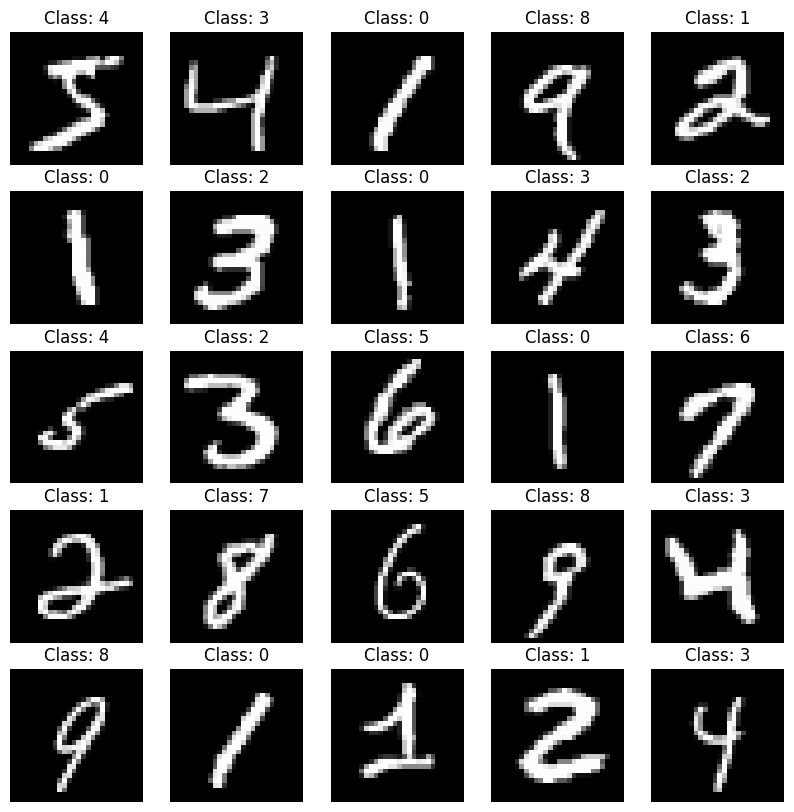

In [ ]:
train_dataset_MNIST1to9_ss = Subset(ds, train_idx)
test_dataset_MNIST1to9_ss = Subset(ds_test, test_idx)

torch.save(train_dataset_MNIST1to9_ss, 'train_MNIST1to9_subset.pt')
torch.save(test_dataset_MNIST1to9_ss, 'test_MNIST1to9_subset.pt')

train_data_MNIST1to9 = torch.load('train_MNIST1to9_subset.pt')
test_data_MNIST1to9 = torch.load('test_MNIST1to9_subset.pt')

train_data_MNIST1to9.dataset.targets = train_data_MNIST1to9.dataset.targets-1
test_data_MNIST1to9.dataset.targets = test_data_MNIST1to9.dataset.targets-1

train_dataset_MNIST1to9_ss_dataloader = DataLoader(train_data_MNIST1to9, shuffle=False, batch_size=100)

print("MNIST 1to9 Train\n")

print("Shift classes by -1 (For N classes, train() needs classes 0..N-1)\n")

print(train_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(train_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))
print(test_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(test_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))

print("")

for j, (images, targets) in enumerate(train_dataset_MNIST1to9_ss_dataloader):

    print("Dataloader Labels (Uniques)\n\n",targets.unique(return_counts=True), len(targets.unique()))
    if(len(targets.unique() == 9)):
      print("\nNine classes.  Class removed successfully")

    print("\nTargets\n\n",targets)

    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(f'Class: {targets[i]}')
      plt.axis("off")
      plt.imshow(images[i].squeeze(), cmap="gray")
    plt.show()

    if j == 0: break



MNIST 1to9 Test


Dataloader Labels (Uniques)

 (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([15,  9, 11, 15,  8, 11, 15,  2, 14])) 9

Nine classes.  Class removed successfully

Targets

 tensor([6, 1, 0, 3, 0, 3, 8, 4, 8, 5, 8, 0, 4, 8, 6, 2, 3, 8, 5, 5, 4, 3, 6, 3,
        0, 2, 0, 2, 3, 6, 1, 6, 0, 1, 0, 0, 6, 3, 1, 2, 4, 0, 1, 3, 3, 5, 2, 4,
        4, 5, 3, 0, 8, 4, 6, 7, 8, 2, 6, 3, 5, 3, 2, 6, 1, 8, 0, 6, 2, 1, 8, 6,
        6, 5, 1, 6, 7, 3, 6, 2, 5, 0, 2, 5, 8, 2, 0, 3, 0, 6, 5, 8, 5, 4, 3, 8,
        8, 1, 0, 8])


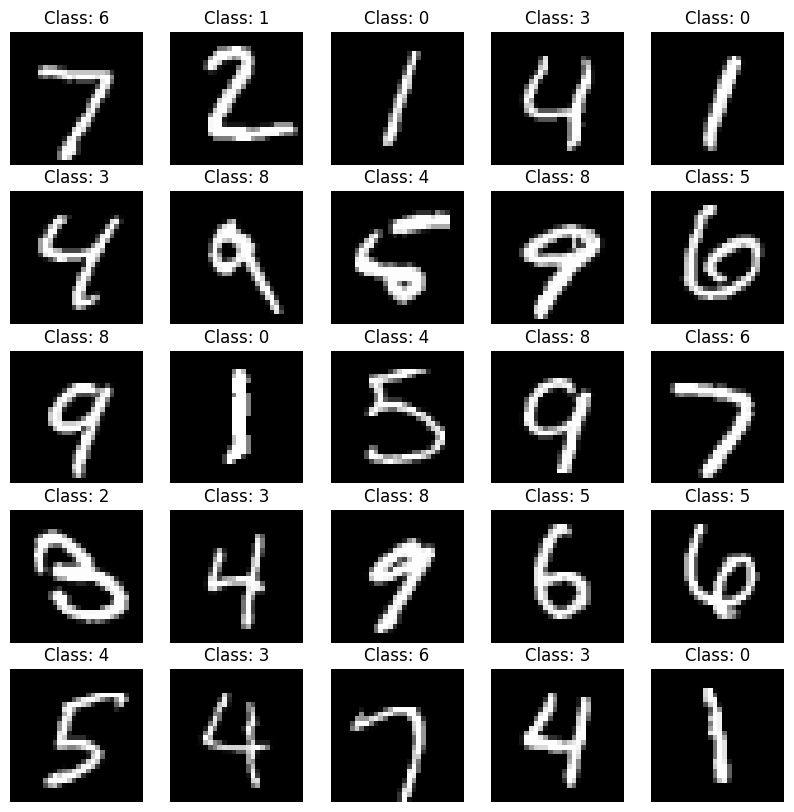

In [ ]:
test_dataset_MNIST1to9_ss_dataloader = DataLoader(test_data_MNIST1to9, shuffle=False, batch_size=100)

print("\n\nMNIST 1to9 Test\n\n")

for j, (images_test, targets_test) in enumerate(test_dataset_MNIST1to9_ss_dataloader):

    print("Dataloader Labels (Uniques)\n\n",targets_test.unique(return_counts=True), len(targets_test.unique(return_counts=True)[0]))

    if(len(targets_test.unique(return_counts=True)[0] == 9)):
      print("\nNine classes.  Class removed successfully")

    print("\nTargets\n\n",targets_test)

    figure = plt.figure(figsize=(10, 10))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(f'Class: {targets_test[i]}')
      plt.axis("off")
      plt.imshow(images_test[i].squeeze(), cmap="gray")
    plt.show()

    if j == 0: break

###Load Loaders

In [ ]:
loaders_MNIST1to9 = {
      'train' : torch.utils.data.DataLoader(train_data_MNIST1to9,
                                            batch_size=100,
                                            shuffle=False,
                                            num_workers=1),

      'test'  : torch.utils.data.DataLoader(test_data_MNIST1to9,
                                            batch_size=100,
                                            shuffle=False,
                                            num_workers=1),
  }

print(loaders_MNIST1to9)
print(len(loaders_MNIST1to9['train']))
print(len(loaders_MNIST1to9['test']))

# #Check there are 10 labels in MNIST and 9 in MNIST 1to9

# for inputs, labels in loaders['train']:
#   # print(inputs[0])
#   print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
#   break

for inputs, labels in loaders_MNIST1to9['train']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

  #Check there are 10 labels in MNIST and 9 in MNIST 1to9

# for inputs, labels in loaders['test']:
#   # print(inputs[0])
#   print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
#   break

for inputs, labels in loaders_MNIST1to9['test']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

{'train': <torch.utils.data.dataloader.DataLoader object at 0x7c949b4ad690>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7c949b4ad660>}
541
91
Shape: torch.Size([100]),
 Labels: tensor([4, 3, 0, 8, 1, 0, 2, 0, 3, 2, 4, 2, 5, 0, 6, 1, 7, 5, 8, 3, 8, 0, 0, 1,
        3, 2, 1, 6, 2, 7, 5, 8, 4, 5, 6, 5, 0, 7, 6, 8, 2, 8, 7, 4, 8, 2, 2, 6,
        3, 8, 7, 8, 3, 0, 3, 3, 5, 3, 4, 5, 0, 0, 6, 0, 5, 2, 1, 0, 0, 6, 8, 1,
        5, 6, 7, 2, 8, 3, 5, 6, 3, 5, 7, 6, 7, 2, 0, 4, 6, 0, 6, 0, 0, 5, 2, 1,
        8, 2, 0, 0]),
 Uniques: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([19,  7, 13, 11,  6, 12, 12,  8, 12])),
 Len 9
Shape: torch.Size([100]),
 Labels: tensor([6, 1, 0, 3, 0, 3, 8, 4, 8, 5, 8, 0, 4, 8, 6, 2, 3, 8, 5, 5, 4, 3, 6, 3,
        0, 2, 0, 2, 3, 6, 1, 6, 0, 1, 0, 0, 6, 3, 1, 2, 4, 0, 1, 3, 3, 5, 2, 4,
        4, 5, 3, 0, 8, 4, 6, 7, 8, 2, 6, 3, 5, 3, 2, 6, 1, 8, 0, 6, 2, 1, 8, 6,
        6, 5, 1, 6, 7, 3, 6, 2, 5, 0, 2, 5, 8, 2, 0, 3, 0, 6, 5, 8, 5, 4, 3, 8,
       

##EMNIST

###Import

In [ ]:
fimportEMNIST = 1
if fimportEMNIST == 1:
  train_data_EMNIST = datasets.EMNIST(
      root = 'data_EMNIST',
      train = True,
      transform = ToTensor(),
      download = True,
      split='letters'
  )
  test_data_EMNIST = datasets.EMNIST(
      root = 'data_EMNIST',
      train = False,
      transform = ToTensor(),
      split='letters'
  )

100%|██████████| 561753746/561753746 [00:23<00:00, 23727014.35it/s]


Extracting data_EMNIST/EMNIST/raw/gzip.zip to data_EMNIST/EMNIST/raw


###Show Data

Train data:  Dataset EMNIST
    Number of datapoints: 124800
    Root location: data_EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Test data:  Dataset EMNIST
    Number of datapoints: 124800
    Root location: data_EMNIST
    Split: Train
    StandardTransform
Transform: ToTensor()
Train data size:  torch.Size([124800, 28, 28])
Test data size:  torch.Size([124800, 28, 28])
Train example 6th row:  tensor([0.0000, 0.0157, 0.4471, 0.9922, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961,
        0.9961, 0.9961, 0.9961, 0.9882, 0.9843, 0.9961, 0.9961, 0.9961, 0.9961,
        0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.9961, 0.4980, 0.0157,
        0.0000])
Targets by class:  (tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26]), tensor([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800]

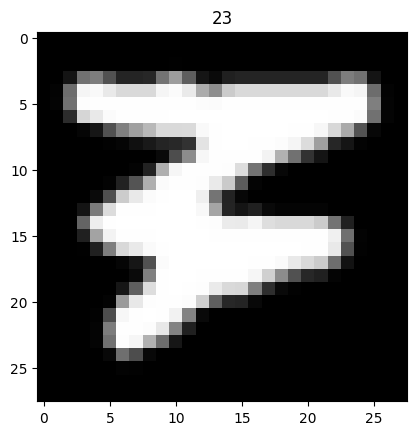

tensor([ 7, 16, 15, 23, 17, 13, 11, 22, 24])


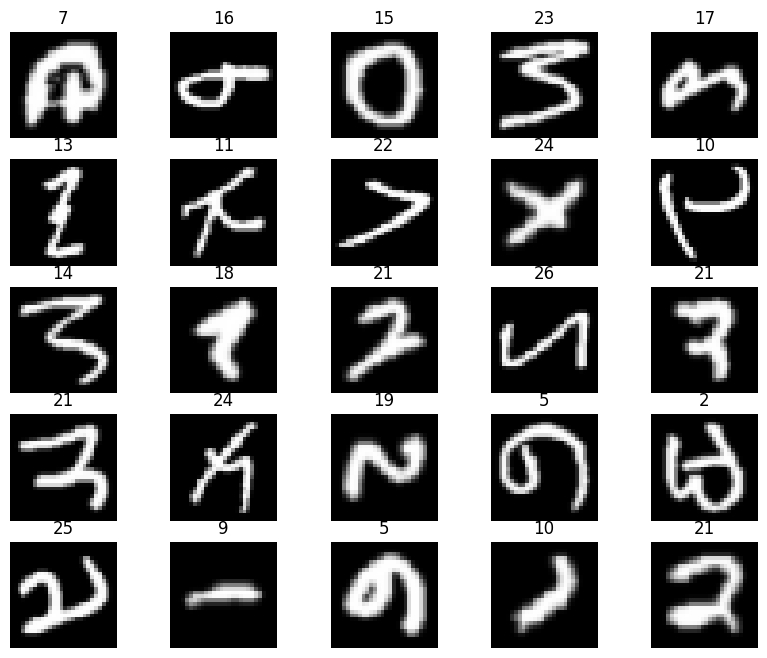

In [ ]:
fshowdata = 1
if fshowdata == 1:
  print("Train data: ", train_data_EMNIST)
  print("Test data: ", train_data_EMNIST)
  print("Train data size: ", train_data_EMNIST.data.size())
  print("Test data size: ", train_data_EMNIST.data.size())
  print("Train example 6th row: ", train_data_EMNIST[0][0][0][5])
  print("Targets by class: ", train_data_EMNIST.targets.unique(return_counts=True))
  print("Test example 5: ", train_data_EMNIST.targets[0])

  plt.imshow(train_data_EMNIST.data[0], cmap='gray')
  plt.title('%i' % train_data_EMNIST.targets[0])
  plt.show()

  print(train_data_EMNIST.targets[1:10])
  figure = plt.figure(figsize=(10, 8))
  cols, rows = 5, 5
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(train_data_EMNIST), size=(1,)).item()
      img, label = train_data_EMNIST[i]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()

###Remove classes and show data

In [ ]:
# Get all targets
ds = train_data_EMNIST
ds_test = test_data_EMNIST

print("EMNIST Train:\n\n",ds.data.shape, "EMNIST Train Targets: ",ds.targets.shape)
print("\nEMNIST Train Targets\n\n ",ds.targets.unique(return_counts=True))
print("\nTotal size - class size\n\n", ds.targets.shape[0]-ds.targets.unique(return_counts=True)[1])
print(ds.classes,"\n\n")

print("EMNIST Test\n",ds_test.data.shape, "EMNIST Test Targets: ",ds_test.targets.shape)
print("\nMNIST Test Targets\n",ds_test.targets.unique(return_counts=True))
print("\nTotal size - class size\n", ds_test.targets.shape[0]-ds_test.targets.unique(return_counts=True)[1])
print(ds_test.classes)

targets = ds.targets
targets_test = ds_test.targets

print(targets)
print(targets_test)

train_idx = np.arange(len(targets))
test_idx = np.arange(len(targets_test))

# Get indices to remove
idx1 = targets[train_idx]!=11
idx2 = targets[train_idx]!=12
idx3 = targets[train_idx]!=13
idx4 = targets[train_idx]!=14
idx5 = targets[train_idx]!=15
idx6 = targets[train_idx]!=16
idx7 = targets[train_idx]!=17
idx8 = targets[train_idx]!=18
idx9 = targets[train_idx]!=19
idx10 = targets[train_idx]!=20
idx11 = targets[train_idx]!=21
idx12 = targets[train_idx]!=22
idx13 = targets[train_idx]!=23
idx14 = targets[train_idx]!=24
idx15 = targets[train_idx]!=25
idx16 = targets[train_idx]!=26
print("Idx1:", idx1.unique(return_counts=True))
print("Idx2:",idx2.unique(return_counts=True))
print("Idx3:",idx3.unique(return_counts=True))
print("Idx4:",idx4.unique(return_counts=True))
print("Idx5:",idx5.unique(return_counts=True))
print("Idx6:",idx6.unique(return_counts=True))
print("Idx7:",idx7.unique(return_counts=True))
print("Idx8:",idx8.unique(return_counts=True))
print("Idx9:",idx9.unique(return_counts=True))
print("Idx10:",idx10.unique(return_counts=True))
print("Idx11:",idx11.unique(return_counts=True))
print("Idx12:",idx12.unique(return_counts=True))
print("Idx13:",idx13.unique(return_counts=True))
print("Idx14:",idx14.unique(return_counts=True))
print("Idx15:",idx15.unique(return_counts=True))
print("Idx16:",idx16.unique(return_counts=True))

# Get test indices to remove
test_idx1 = targets_test[test_idx]!=11
test_idx2 = targets_test[test_idx]!=12
test_idx3 = targets_test[test_idx]!=13
test_idx4 = targets_test[test_idx]!=14
test_idx5 = targets_test[test_idx]!=15
test_idx6 = targets_test[test_idx]!=16
test_idx7 = targets_test[test_idx]!=17
test_idx8 = targets_test[test_idx]!=18
test_idx9 = targets_test[test_idx]!=19
test_idx10 = targets_test[test_idx]!=20
test_idx11 = targets_test[test_idx]!=21
test_idx12 = targets_test[test_idx]!=22
test_idx13 = targets_test[test_idx]!=23
test_idx14 = targets_test[test_idx]!=24
test_idx15 = targets_test[test_idx]!=25
test_idx16 = targets_test[test_idx]!=26
print("test_Idx1:",test_idx1.unique(return_counts=True))
print("test_Idx2:",test_idx2.unique(return_counts=True))
print("test_Idx3:",test_idx3.unique(return_counts=True))
print("test_Idx4:",test_idx4.unique(return_counts=True))
print("test_Idx5:",test_idx5.unique(return_counts=True))
print("test_Idx6:",test_idx6.unique(return_counts=True))
print("test_Idx7:",test_idx7.unique(return_counts=True))
print("test_Idx8:",test_idx8.unique(return_counts=True))
print("test_Idx9:",test_idx9.unique(return_counts=True))
print("test_Idx10:",test_idx10.unique(return_counts=True))
print("test_Idx11:",test_idx11.unique(return_counts=True))
print("test_Idx12:",test_idx12.unique(return_counts=True))
print("test_Idx13:",test_idx13.unique(return_counts=True))
print("test_Idx14:",test_idx14.unique(return_counts=True))
print("test_Idx15:",test_idx15.unique(return_counts=True))
print("test_Idx16:",test_idx16.unique(return_counts=True))

# Only keep your desired classes
train_idx = train_idx[((((((((((((((idx1 == idx2) == idx3)==idx4)==idx5)==idx6)==idx7)==idx8)==idx9)==idx10)==idx11)==idx12)==idx13)==idx14)==idx15)==idx16]
print("Train idx Shape:", train_idx.shape)

test_idx = test_idx[((((((((((((((test_idx1 == test_idx2) == test_idx3)==test_idx4)==test_idx5)==test_idx6)==test_idx7)==test_idx8)==test_idx9)==test_idx10)==test_idx11)==test_idx12)==test_idx13)==test_idx14)==test_idx15)==test_idx16]
print("Test idx Shape:", test_idx.shape)

train_dataset_EMNIST_10L_ss = Subset(ds, train_idx)
test_dataset_EMNIST_10L_ss = Subset(ds_test, test_idx)

torch.save(train_dataset_EMNIST_10L_ss, 'train_dataset_EMNIST_10L_subset.pt')
torch.save(test_dataset_EMNIST_10L_ss, 'test_dataset_EMNIST_10L_subset.pt')

train_data_EMNIST_10L = torch.load('train_dataset_EMNIST_10L_subset.pt')
test_data_EMNIST_10L = torch.load('test_dataset_EMNIST_10L_subset.pt')

train_data_EMNIST_10L.dataset.targets = train_data_EMNIST_10L.dataset.targets-1
test_data_EMNIST_10L.dataset.targets = test_data_EMNIST_10L.dataset.targets-1

EMNIST Train:

 torch.Size([124800, 28, 28]) EMNIST Train Targets:  torch.Size([124800])

EMNIST Train Targets

  (tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26]), tensor([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800,
        4800, 4800]))

Total size - class size

 tensor([120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
        120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000,
        120000, 120000, 120000, 120000, 120000, 120000, 120000, 120000])
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 


EMNIST Test
 torch.Size([20800, 28, 28]) EMNIST Test Targets:  torch.Size([20800])

MNIST Test Targets
 (tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,

EMNIST 10 Letters Train

Shift classes by -1 (For N classes, train() needs classes 0..N-1)

(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])) 10
(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])) 10



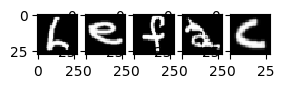

tensor([7, 4, 5, 0, 2, 8, 1, 3, 1, 7, 3, 8, 6, 1, 4, 8, 8, 5, 5, 5, 7, 4, 5, 6,
        5, 0, 9, 8, 0, 7, 8, 0, 4, 0, 7, 1, 9, 7, 5, 8, 6, 1, 2, 0, 4, 4, 0, 1,
        7, 0, 2, 5, 9, 2, 6, 8, 1, 2, 4, 1, 8, 6, 5, 4, 0, 0, 5, 9, 4, 2, 4, 2,
        3, 2, 2, 3, 0, 8, 0, 8, 5, 2, 4, 2, 9, 1, 3, 6, 2, 8, 3, 4, 8, 5, 7, 5,
        9, 4, 7, 0])


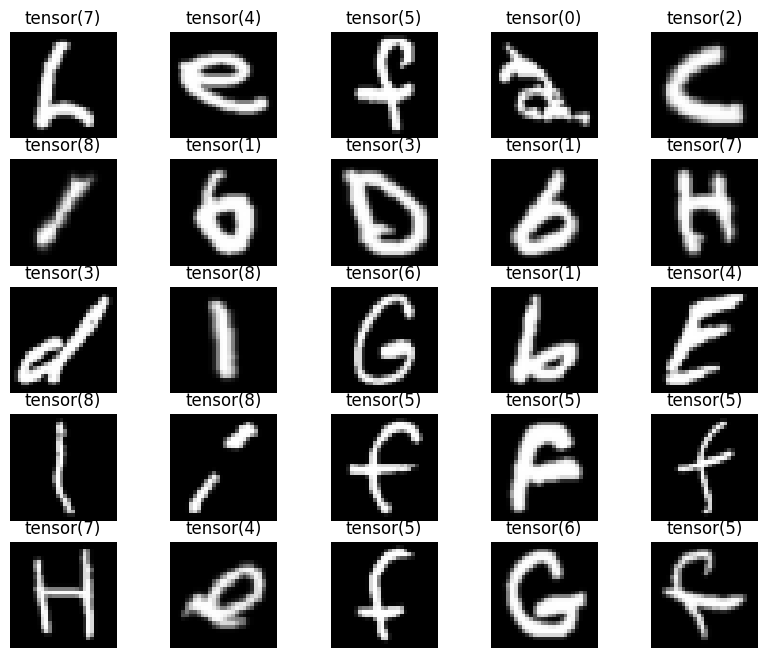

In [ ]:
train_dataset_EMNIST_10L_ss_dataloader = DataLoader(train_data_EMNIST_10L, shuffle=True, batch_size=100)

print("EMNIST 10 Letters Train\n")

print("Shift classes by -1 (For N classes, train() needs classes 0..N-1)\n")

print(train_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(train_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))
print(test_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(test_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))

print("")

for j, (images, targets) in enumerate(train_dataset_EMNIST_10L_ss_dataloader):
    ax = plt.figure(figsize=(3, 1))

    ax.add_subplot(1, 5, 1)
    plt.imshow(torch.flip(torch.rot90(images[0][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 2)
    plt.imshow(torch.flip(torch.rot90(images[1][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 3)
    plt.imshow(torch.flip(torch.rot90(images[2][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 4)
    plt.imshow(torch.flip(torch.rot90(images[3][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 5)
    plt.imshow(torch.flip(torch.rot90(images[4][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.show()
    # ax.set_aspect(5)

    plt.show()
    # plt.figure(figsize=(10, 8))
    # print(images)
    print(targets)
    # plt.imshow(images[0][0], cmap='gray')
    # plt.title('%i' % targets[0])

    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(targets[i])
      plt.axis("off")
      plt.imshow(torch.flip(torch.rot90(images[i].squeeze(),1),[0]), cmap="gray")
    plt.show()

    if j == 0: break

EMNIST 10 Letters Test

Shift classes by -1 (For N classes, train() needs classes 0..N-1)

(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])) 10
(tensor([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8]), tensor([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009])) 10



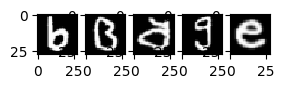

tensor([1, 1, 0, 6, 4, 6, 6, 9, 0, 0, 3, 9, 4, 9, 6, 7, 0, 1, 0, 5, 5, 2, 9, 2,
        2, 5, 4, 6, 7, 0, 8, 1, 1, 6, 8, 0, 2, 6, 6, 1, 0, 2, 1, 6, 2, 6, 7, 4,
        2, 5, 3, 2, 5, 9, 8, 0, 6, 4, 0, 8, 7, 5, 8, 0, 2, 6, 5, 7, 8, 1, 1, 5,
        1, 5, 6, 6, 7, 0, 2, 1, 1, 0, 1, 3, 1, 3, 2, 7, 9, 7, 0, 1, 6, 9, 3, 4,
        1, 2, 8, 9])


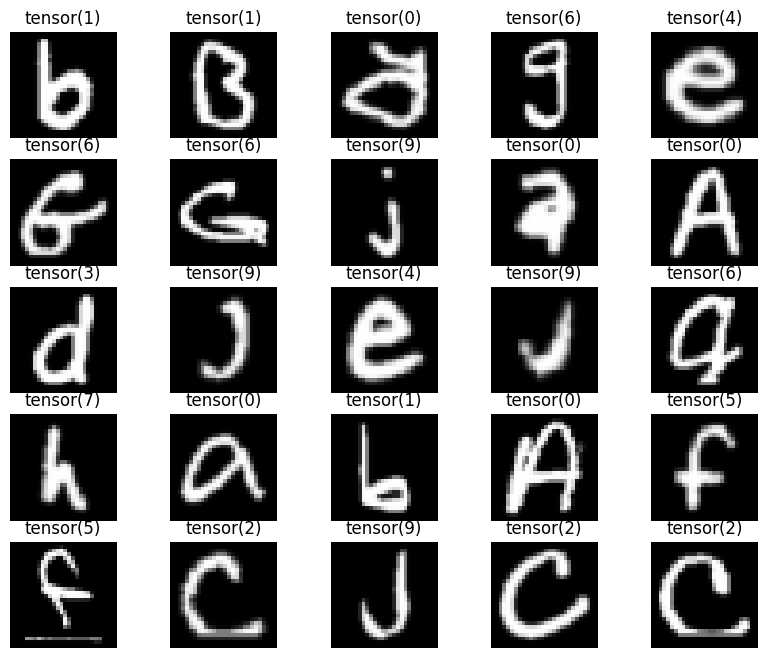

In [ ]:
test_dataset_EMNIST_10L_ss_dataloader = DataLoader(test_data_EMNIST_10L, shuffle=True, batch_size=100)

print("EMNIST 10 Letters Test\n")

print("Shift classes by -1 (For N classes, train() needs classes 0..N-1)\n")

print(train_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(train_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))
print(test_data_MNIST1to9.dataset.targets.unique(return_counts=True), len(test_data_MNIST1to9.dataset.targets.unique(return_counts=True)[1]))

print("")

for j, (images, targets) in enumerate(test_dataset_EMNIST_10L_ss_dataloader):
    ax = plt.figure(figsize=(3, 1))

    ax.add_subplot(1, 5, 1)
    plt.imshow(torch.flip(torch.rot90(images[0][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 2)
    plt.imshow(torch.flip(torch.rot90(images[1][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 3)
    plt.imshow(torch.flip(torch.rot90(images[2][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 4)
    plt.imshow(torch.flip(torch.rot90(images[3][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.add_subplot(1, 5, 5)
    plt.imshow(torch.flip(torch.rot90(images[4][0],1),[0]), interpolation='nearest', cmap='gray')
    ax.show()
    # ax.set_aspect(5)

    plt.show()
    # plt.figure(figsize=(10, 8))
    # print(images)
    print(targets)
    # plt.imshow(images[0][0], cmap='gray')
    # plt.title('%i' % targets[0])

    figure = plt.figure(figsize=(10, 8))
    cols, rows = 5, 5
    for i in range(0, cols * rows):
      figure.add_subplot(rows, cols, i+1)
      plt.title(targets[i])
      plt.axis("off")
      plt.imshow(torch.flip(torch.rot90(images[i].squeeze(),1),[0]), cmap="gray")
    plt.show()

    if j == 0: break

###Load Loaders

In [ ]:
loaders = {
    'train' : torch.utils.data.DataLoader(train_data_EMNIST_10L,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),

    'test'  : torch.utils.data.DataLoader(test_data_EMNIST_10L,
                                          batch_size=100,
                                          shuffle=True,
                                          num_workers=1),
}

print(len(loaders['train']))
print(len(loaders['test']))

#Check there are 10 labels in EMNIST and 9 in MNIST 1to9

for inputs, labels in loaders['train']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

for inputs, labels in loaders_MNIST1to9['train']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

  #Check there are 10 labels in MNIST and 9 in MNIST 1to9

for inputs, labels in loaders['test']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

for inputs, labels in loaders_MNIST1to9['test']:
  # print(inputs[0])
  print(f"Shape: {labels.shape},\n Labels: {labels},\n Uniques: {labels.unique(return_counts=True)},\n Len {len(labels.unique())}")
  break

480
80
Shape: torch.Size([100]),
 Labels: tensor([4, 7, 5, 8, 6, 2, 5, 4, 5, 8, 4, 6, 8, 5, 2, 9, 5, 0, 6, 8, 0, 2, 3, 1,
        6, 2, 1, 2, 7, 5, 0, 9, 2, 1, 7, 6, 5, 9, 7, 6, 4, 4, 4, 0, 0, 1, 8, 3,
        5, 6, 1, 0, 6, 6, 2, 2, 3, 5, 1, 3, 6, 5, 8, 4, 4, 6, 9, 7, 1, 4, 9, 0,
        0, 1, 0, 2, 9, 0, 7, 7, 3, 3, 8, 0, 6, 3, 4, 4, 0, 8, 9, 8, 7, 8, 2, 6,
        1, 0, 9, 8]),
 Uniques: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([13,  9, 10,  7, 11, 10, 13,  8, 11,  8])),
 Len 10
Shape: torch.Size([100]),
 Labels: tensor([4, 3, 0, 8, 1, 0, 2, 0, 3, 2, 4, 2, 5, 0, 6, 1, 7, 5, 8, 3, 8, 0, 0, 1,
        3, 2, 1, 6, 2, 7, 5, 8, 4, 5, 6, 5, 0, 7, 6, 8, 2, 8, 7, 4, 8, 2, 2, 6,
        3, 8, 7, 8, 3, 0, 3, 3, 5, 3, 4, 5, 0, 0, 6, 0, 5, 2, 1, 0, 0, 6, 8, 1,
        5, 6, 7, 2, 8, 3, 5, 6, 3, 5, 7, 6, 7, 2, 0, 4, 6, 0, 6, 0, 0, 5, 2, 1,
        8, 2, 0, 0]),
 Uniques: (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([19,  7, 13, 11,  6, 12, 12,  8, 12])),
 Len 9
Shape: torch.Size([100]),
 

In [ ]:
# for i, (images, labels) in enumerate(loaders['train']):
#   print(i)
#   print(labels)
#   print(len(labels))

#Networks

##Functions

In [ ]:
def save_network(network):
  store_network_tensors = []

  for named_param in network.named_parameters():
      store_network_tensors.append(named_param)

  return store_network_tensors


In [ ]:
def check_network(network1, network2):
  for named_param in network1.named_parameters():
      # print(f"For {named_param[0]}")
      for stored_param in network2.named_parameters():
        if(named_param[0] in stored_param[0]):
          # print(named_param[1])
          # print(stored_param[1])
          if(named_param[1].shape == stored_param[1].shape):
            print(f"{torch.allclose(named_param[1],stored_param[1])} is same for {named_param[0]}")
          else:
            print(f"Shapes do not match for {named_param[0]} and {stored_param[0]}")

In [ ]:
def load_state_dict_conv_layer(network, state):

      # with torch.no_grad():
        network_state = network.state_dict()
        # print(network_state['conv1.weight'][0:1])
        # print(sscnn_sa_1to9.state_dict()['conv1.weight'][0:1])
        for name, param in state.items():
            if(name == 'conv1.weight' or name == 'conv1.bias'):
              # print("State to load: ", name, param[0])
              # print("Network before: ", name, network_state[name][0])
              # print(param.requires_grad)
              network_state[name].copy_(param)
              # print("Network after: ", name, network_state[name][0])

              # if isinstance(param, Parameter):
              #     # backwards compatibility for serialized parameters
              #     param = param.data
              # net_state[name].copy_(param)

In [ ]:
def load_state_dict_ft(network, state):

      with torch.no_grad():
        net_state = network.state_dict()
        for name, param in state.items():
            if name not in net_state:
                  continue
            else:
              print(name, param[0:1])
              print(net_state[name][0:1])
              if( net_state[name].shape != param.shape):
                print("Shape's do not match for ", name, net_state[name].shape)
                print("Before: ", net_state[name][0:1], net_state[name].shape)
                # net_state[name] = copy.deepcopy(param)
                print("After: ", net_state[name], net_state[name].shape)

              else:
                net_state[name] = copy.deepcopy(param)
                print("Updated name")

            # if isinstance(param, Parameter):
            #     # backwards compatibility for serialized parameters
            #     param = param.data
            # net_state[name].copy_(param)

In [ ]:
def train(num_epochs, cnn, loaders, optimizer, loss_func):

    print("Training beginning")
    cnn.train()

    # Train the model
    total_step = len(loaders['train'])
    count = 0

    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(loaders['train']):

          # count = count + 1

          # print("Step start")

          # gives batch data, normalize x when iterate train_loader
          b_x = Variable(images)   # batch x
          b_y = Variable(labels)   # batch y
          # print("b_x: ", b_x.shape)
          # print("b_y: ", b_y.shape)

          output = cnn(b_x)
          # output = cnn(b_x)[0]
          # print("output shape: ", output.shape)

          loss = loss_func(output, b_y)
          # print("loss shape: ", loss.shape)

          # clear gradients for this training step
          optimizer.zero_grad()

          # backpropagation, compute gradients
          loss.backward()
          # apply gradients
          optimizer.step()

          # print("Step done")
          # print('Epoch [{}/{}], i [{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, i+1, total_step, loss.item()))

          if (i+1) % total_step == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.2f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
          pass

        # print(count)
        pass



    pass

In [ ]:
def train_with_accuracy(num_epochs, cnn, loaders, optimizer, loss_func):

    train_accuracy_list = []

    print("\nTraining beginning")
    cnn.train()

    total_step = len(loaders['train'])

    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(loaders['train']):

          b_x = Variable(images)   # batch x
          b_y = Variable(labels)   # batch y
          # print("b_x: ", b_x.shape)
          # print("b_y: ", b_y.shape)

          output = cnn(b_x)
          # output = cnn(b_x)[0]
          # print("output shape: ", output.shape)

          loss = loss_func(output, b_y)
          # print("loss shape: ", loss.shape)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          # print("Step done")
          # print('Epoch [{}/{}], i [{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i, i+1, total_step, loss.item()))

          if (i+1) % total_step == 0:
              print ('\nEpoch [{}/{}], Step [{}/{}], Loss: {:.2f}'
                      .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
          pass

        train_accuracy_element = test_and_show(cnn, loaders, text=False, graph_mode=0, rotate=False)
        train_accuracy_list.append(train_accuracy_element)
        cnn.train()

        pass
    pass

    print("Returning train accuracy list")
    return train_accuracy_list

In [ ]:
def old_test(cnn, loaders):
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output = cnn(images)

            # Take maximum label prediction
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))

            pass

        print('Test Accuracy of the model on the 10000 test images: %.4f' % accuracy)

    pass


In [ ]:
def test_and_show(cnn, loaders, text=0, graph_mode=0, rotate=False):
    # Test the model
    test_accuracy_list = []
    cnn.eval()
    with torch.no_grad():

        correct = 0
        total = 0
        accuracy = 0
        # print(f"C: {correct}, T: {total}, A: {accuracy}")

        for images, labels in loaders['test']:

            #Batches
            # print(f"\nLengths\nImages: {len(images)}, Labels: {len(labels)}")
            total = total + len(images)

            test_output = cnn(images)

            # print("Out: ", test_output.shape, test_output[0:2])

            # Take maximum label prediction
            pred_y = torch.max(test_output, 1)[1].data.squeeze()

            # print("Pred_y: ", pred_y.shape, pred_y)
            # print("Pred_y == labels ", (pred_y == labels).shape, (pred_y == labels), (pred_y == labels).sum().item())

            correct = correct + (pred_y == labels).sum().item()
            # print(f"C: {correct}, T: {total}, A: {accuracy}")
            # print(f"accuracy per 100 {(pred_y == labels).sum().item() / float(labels.size(0))}")

        print(f"C: {correct}, T: {total}, A: {accuracy}")
        accuracy = correct/total
        print(f'Test Accuracy of the model on the {total} test images. Correct: {correct} : {accuracy*100}')
        test_accuracy_list.append(accuracy)

    if(graph_mode >= 1):

      sample = next(iter(loaders['test']))

      imgs, lbls = sample
      actual_number = lbls[:100].numpy()
      actual_number

      test_output = cnn(imgs[:100])

      pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
      print("Targets: ", torch.from_numpy(actual_number).unique(return_counts=True), len(actual_number), len(pred_y))


      if(graph_mode >= 2):

        figure = plt.figure(figsize=(10, 8))
        cols, rows = 5, 5
        for i in range(0, cols * rows):
              # sample_idx = torch.randint(len(train_data), size=(1,)).item()
              # img, label = train_data[i]
              figure.add_subplot(rows, cols, i+1)
              plt.title(lbls[i])
              plt.axis("off")
              if(rotate == True):
                plt.imshow(torch.flip(torch.rot90(imgs[i].squeeze(),1),[0]), cmap="gray")
              else:
                plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.show()

        figure = plt.figure(figsize=(10, 8))
        cols, rows = 5, 5
        for i in range(0, cols * rows):
              # sample_idx = torch.randint(len(train_data), size=(1,)).item()
              # img, label = train_data[i]
              figure.add_subplot(rows, cols, i+1)
              plt.title(pred_y[i])
              plt.axis("off")
              if(rotate == True):
                plt.imshow(torch.flip(torch.rot90(imgs[i].squeeze(),1),[0]), cmap="gray")
              else:
                plt.imshow(imgs[i].squeeze(), cmap="gray")
        plt.show()

    if(text == True):
        count_25 = 0
        count_nine = 0
        for x in np.arange(0, len(pred_y)):
          count_25 = count_25+1
          if(count_25 < 26):
            print(f'P: {pred_y[x]} A: {actual_number[x]} T: {(pred_y == actual_number)[x]}')
            if(actual_number[x] == 0):
              print(f'Zero {(pred_y == actual_number)[x]}')
            elif (actual_number[x] == 9):
              print(f'Nine {(pred_y == actual_number)[x]}')
              count_nine = count_nine + 1
          else:
            break

        if count_nine == 0:
          print("No nine class detected")
        else:
          print("Class nine detected")
    print("Returning test accuracy list")
    return test_accuracy_list

##Definitions

In [ ]:
class SSCNN(nn.Module):

    # Default parameters
    def __init__(self, outc = 6, out_class = 10, adapt=0, softmax=0, padding=0):

        super(SSCNN, self).__init__()
        self.outc = outc
        self.KxK = 5
        self.out_class = out_class
        self.adapt = adapt
        self.softmax = softmax
        self.padding = padding

        self.conv1 = nn.Conv2d(
                #KxK
                in_channels=1,
                out_channels= self.outc,
                kernel_size=self.KxK,
                stride=1,

                padding=self.padding,

                bias=True,
            )

        self.conv1sa = nn.Conv2d(
                #1x1 serial
                in_channels=self.outc,
                out_channels= self.outc,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

        self.conv1pa = nn.Conv2d(
                #1x1 parallel
                in_channels=1,
                out_channels= self.outc,
                kernel_size=1,
                stride=1,
                padding=0,
                bias=True,
            )

        self.actv = nn.ReLU()
        # self.actv = nn.Sigmoid()

        if (softmax == 1):
          # self.out_actv = nn.Softmax(dim=1)
          self.out_actv = nn.Sigmoid()
        else:
          self.out_actv = nn.Sigmoid()
          # self.out_actv = nn.ReLU()

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)


        if(self.padding == 2):
          # Conv Padding = 2
          self.fc = nn.Linear(196*self.outc, 45, bias=True)
        else:
          # self.fc = nn.Linear(196*self.outc, 45, bias=True)
          # Conv Padding = 0
          self.fc = nn.Linear(144*self.outc, 45, bias=True)

        self.out = nn.Linear(45,self.out_class, bias=True)

    def forward(self, x):

        # print("Dataflow")
        if(self.adapt == 0):
          # print("1. Input X: ",x.shape)
          x = self.conv1(x)
          # print("2. conv1(x): ",x.shape)
          x = self.actv(x)
          # print("3. conv_actv(x): ",x.shape)
          x = self.pool(x)
          # print("4. pool(x): ",x.shape)

        elif(self.adapt == 1):
          #Add conv outputs in serial before activation
          # print("1. Input X: ",x.shape)
          x = self.conv1(x)
          # print("2. conv1(x): ",x.shape)
          dx = self.conv1sa(x)
          # print("3. adapt(x): ",dx.shape)
          x = self.actv(x + dx)
          # print("4. conv_actv(x): ",x.shape)
          x = self.pool(x)
          # print("5. pool(x): ",x.shape)

        elif(self.adapt == 2):
          #Add conv outputs in parallel before activation
          # print("1. Input X: ",x.shape)
          xc = self.conv1(x)
          # print("2. conv1(x): ",xc.shape)
          dx = self.conv1pa(x)
          # print("3. adapt(x): ",dx.shape)
          # print(xc.shape)
          # print(dx.shape)
          x = self.actv(xc + dx)
          # print("4. conv_actv(x): ",x.shape)
          x = self.pool(x)
          # print("5. pool(x): ",x.shape)

        # Flatten output for FC
        x = x.view(x.size(0), -1)
        # print("6a. flatten(x): ",x.shape)
        x = self.fc(x)
        # print("6b. FC(x): ",x.shape)
        x = self.actv(x)
        # print("7. actv(x): ",x.shape)

        output = self.out(x)
        # print("8. out(x): ",output.shape)
        output_actv = self.actv(output)
        # print("9. out_actv(x): ",output_actv.shape)

        return output_actv # should return [batch_size, numclass] for use in train()

        #return output, x  #for visualisation

#Train Networks

In [ ]:
num_epochs = 15
trials = 10

outchannels = 6
outclass = 10

outchannels_1to9 = 6
outclass_1to9 = 9

learning_rate_1 = 0.1

##SSCNN1to9

###Initialise and Train

####Initialise

In [ ]:
sscnn_base = SSCNN(outc = outchannels_1to9, out_class = outclass_1to9, adapt = 0, softmax = 0, padding = 2)
loss_func_sscnn_base = nn.CrossEntropyLoss()
optimizer_sscnn_base = optim.SGD(sscnn_base.parameters(), lr = learning_rate_1)
print("SSCNN Outc: ", sscnn_base.outc)
print("SSCNN Padding: ", sscnn_base.padding)
print("SSCNN Outclass: ", sscnn_base.out_class)
print("SSCNN Adapt: ", sscnn_base.adapt)

SSCNN Outc:  6
SSCNN Padding:  2
SSCNN Outclass:  9
SSCNN Adapt:  0


In [ ]:
print(sscnn_base)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=9, bias=True)
)


####Train

In [ ]:
# for named_param in sscnn_1to9.named_parameters():
#     if named_param[0] == 'conv1.weight':
#       print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
#     elif named_param[0] == 'conv1sa.weight' :
#       print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
#     elif named_param[0] == 'conv1pa.weight' :
#       print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
#     elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
#       print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)

In [ ]:
print("sscnn_base")
# saved_network_param = save_network(sscnn_1to9)
# check_network(sscnn_1to9, saved_network_param)
# num_epochs = 15
copy_sscnn_base = copy.deepcopy(sscnn_base)
train_with_accuracy(num_epochs, sscnn_base, loaders_MNIST1to9, optimizer_sscnn_base, loss_func_sscnn_base)
# train_with_accuracy(20, sscnn_1to9, loaders_MNIST1to9, optimizer_sscnn_1to9, loss_func_sscnn_1to9)
check_network(sscnn_base, copy_sscnn_base)

sscnn_base

Training beginning

Epoch [1/15], Step [541/541], Loss: 0.24
C: 8177, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8177 : 90.65410199556541
Returning test accuracy list

Epoch [2/15], Step [541/541], Loss: 0.21
C: 8514, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8514 : 94.39024390243902
Returning test accuracy list

Epoch [3/15], Step [541/541], Loss: 0.21
C: 8651, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8651 : 95.9090909090909
Returning test accuracy list

Epoch [4/15], Step [541/541], Loss: 0.21
C: 8730, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8730 : 96.7849223946785
Returning test accuracy list

Epoch [5/15], Step [541/541], Loss: 0.20
C: 8768, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8768 : 97.20620842572062
Returning test accuracy list

Epoch [6/15], Step [541/541], Loss: 0.20
C: 8793, T: 9020, A: 0
Test A

In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Name\t\t Training?\t Not Trained? (Values close?)")

for named_param in sscnn_base.named_parameters():
  for named_param2 in copy_sscnn_base.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 True 		 False
conv1.bias 	 True 		 False
conv1sa.weight 	 True 		 True
conv1sa.bias 	 True 		 True
conv1pa.weight 	 True 		 True
conv1pa.bias 	 True 		 True
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 False
out.bias 	 True 		 False


In [ ]:
for named_param in sscnn_base.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)


SSCNN:  conv1.weight tensor([[ 0.2982,  0.1764,  0.0157, -0.1633, -0.3611],
        [-0.1594, -0.0424,  0.3110,  0.1388, -0.4448],
        [ 0.0227, -0.0858,  0.1397,  0.4910,  0.1573],
        [-0.1969, -0.1107, -0.0570,  0.1190,  0.4604],
        [-0.2211, -0.2909, -0.3192, -0.2600,  0.3774]],
       grad_fn=<SelectBackward0>) True

SSCNN:  conv1sa.weight tensor([[[ 0.0490]],

        [[-0.3644]],

        [[-0.1038]],

        [[-0.1167]],

        [[ 0.0319]],

        [[-0.3691]]], grad_fn=<SelectBackward0>) True

SSCNN:  conv1pa.weight Parameter containing:
tensor([[[[ 0.9597]]],


        [[[-0.5799]]],


        [[[ 0.9396]]],


        [[[-0.6509]]],


        [[[-0.6938]]],


        [[[-0.2299]]]], requires_grad=True) True

SSCNN Others:  fc.weight tensor(0.0094, grad_fn=<SelectBackward0>) True

SSCNN Others:  out.weight tensor(-0.0387, grad_fn=<SelectBackward0>) True


####Accuracy

In [ ]:
# test(sscnn_1to9, loaders_MNIST1to9)
test_and_show(sscnn_base, loaders_MNIST1to9, text=False, graph_mode=0, rotate=False)

C: 8872, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8872 : 98.35920177383592
Returning test accuracy list


[0.9835920177383592]

C: 8872, T: 9020, A: 0
Test Accuracy of the model on the 9020 test images. Correct: 8872 : 98.35920177383592
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8]), tensor([15,  9, 11, 15,  8, 11, 15,  2, 14])) 100 100


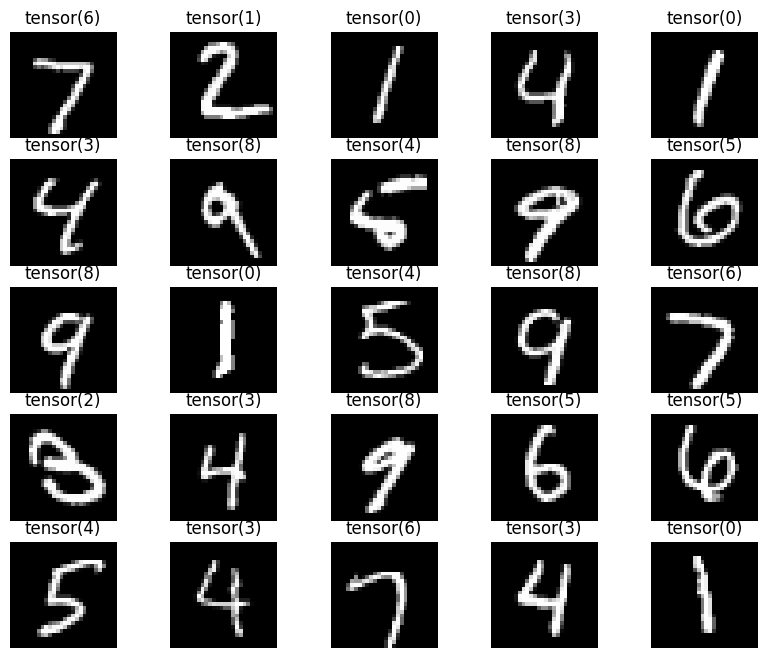

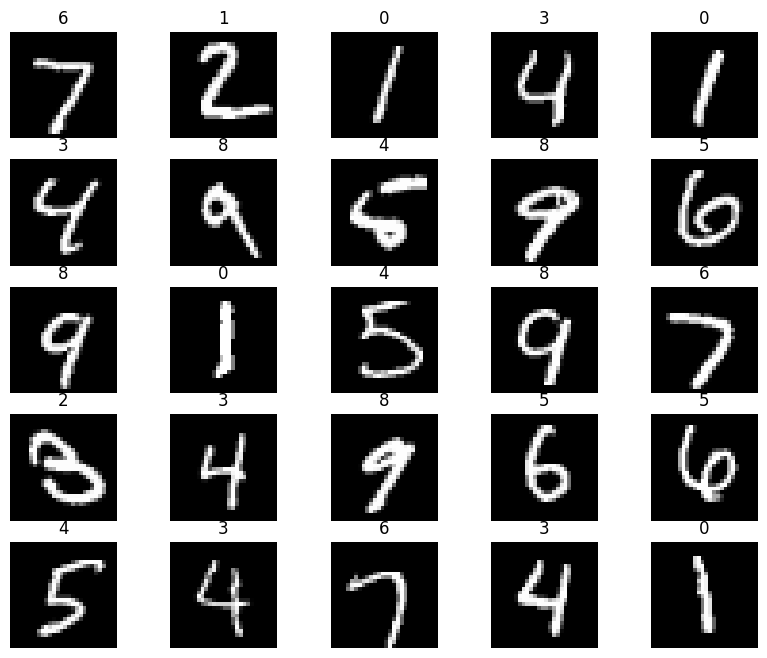

Returning test accuracy list


[0.9835920177383592]

In [ ]:
test_and_show(sscnn_base, loaders_MNIST1to9, text=False, graph_mode=2, rotate=False)

##SSCNN_SA

###Initialise and Train

####Initialise

In [ ]:
sscnn_sa = SSCNN(outc = outchannels, out_class = outclass, adapt = 1, softmax = 0, padding = 0)
loss_func_sscnn_sa = nn.CrossEntropyLoss()
optimizer_sscnn_sa = optim.SGD(sscnn_sa.parameters(), lr = learning_rate_1)
print("SSCNN Outc: ", sscnn_sa.outc)
print("SSCNN Padding: ", sscnn_sa.padding)
print("SSCNN Outclass: ", sscnn_sa.out_class)
print("SSCNN Adapt: ", sscnn_sa.adapt)

SSCNN Outc:  6
SSCNN Padding:  0
SSCNN Outclass:  10
SSCNN Adapt:  1


In [ ]:
print(sscnn_sa)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=864, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
copy_sscnn_for_sa = copy.deepcopy(sscnn_base)
copy_sscnn_for_sa.train()

load_state_dict_conv_layer(sscnn_sa, copy_sscnn_for_sa.state_dict())

# print(sscnn_sa.state_dict()['conv1.weight'][0:1])
# print(sscnn_sa.conv1)
# print(f"For conv1.weight: {torch.allclose(sscnn_sa.state_dict()['conv1.weight'],sscnn_sa.state_dict()['conv1.weight'])}")

for param in sscnn_sa.conv1.parameters():
  # print(param)
  # print("Train (Grad)?:", param.requires_grad)
  param.requires_grad = False
  # print("Train (Grad)?:", param.requires_grad)


In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Name\t\t Training?\t Not Trained? (Values close?)")

for named_param in sscnn_base.named_parameters():
  for named_param2 in sscnn_sa.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 Size's do not match for  fc.weight
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias


####Train

In [ ]:
print("Training sscnn_sa_1to9")
copy_sscnn_sa = copy.deepcopy(sscnn_sa)
train_with_accuracy(num_epochs, sscnn_sa, loaders, optimizer_sscnn_sa, loss_func_sscnn_sa)
print("")
print("Test sameness of SA sscnn before training to after training")
check_network(sscnn_sa, copy_sscnn_sa)
print("")
print("Test sameness of ssccn to serial adapter sscnn")
check_network(sscnn_sa, sscnn_base)

Training sscnn_sa_1to9

Training beginning

Epoch [1/15], Step [480/480], Loss: 0.25
C: 7381, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7381 : 92.2625
Returning test accuracy list

Epoch [2/15], Step [480/480], Loss: 0.25
C: 7456, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7456 : 93.2
Returning test accuracy list

Epoch [3/15], Step [480/480], Loss: 0.15
C: 7514, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7514 : 93.925
Returning test accuracy list

Epoch [4/15], Step [480/480], Loss: 0.07
C: 7565, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7565 : 94.5625
Returning test accuracy list

Epoch [5/15], Step [480/480], Loss: 0.05
C: 7592, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7592 : 94.89999999999999
Returning test accuracy list

Epoch [6/15], Step [480/480], Loss: 0.23
C: 7563, T: 8000, A: 0
Test Accuracy of the model on the 80

####Accuracy

In [ ]:
# test(sscnn_sa_1to9, loaders)
test_and_show(sscnn_sa, loaders, text=False, graph_mode=0, rotate=False)

C: 7658, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7658 : 95.72500000000001
Returning test accuracy list


[0.95725]

C: 7658, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7658 : 95.72500000000001
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 9,  4, 11, 18, 17,  7,  4, 10,  7, 13])) 100 100


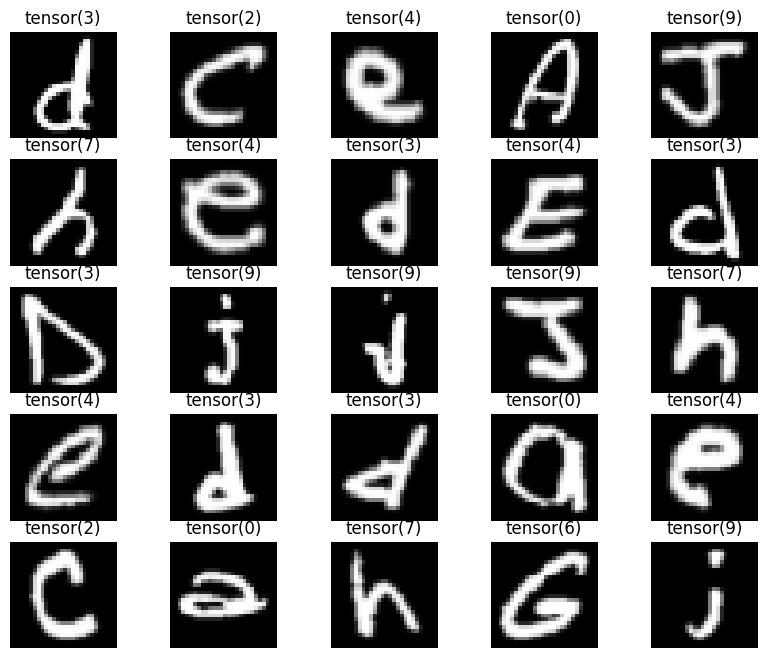

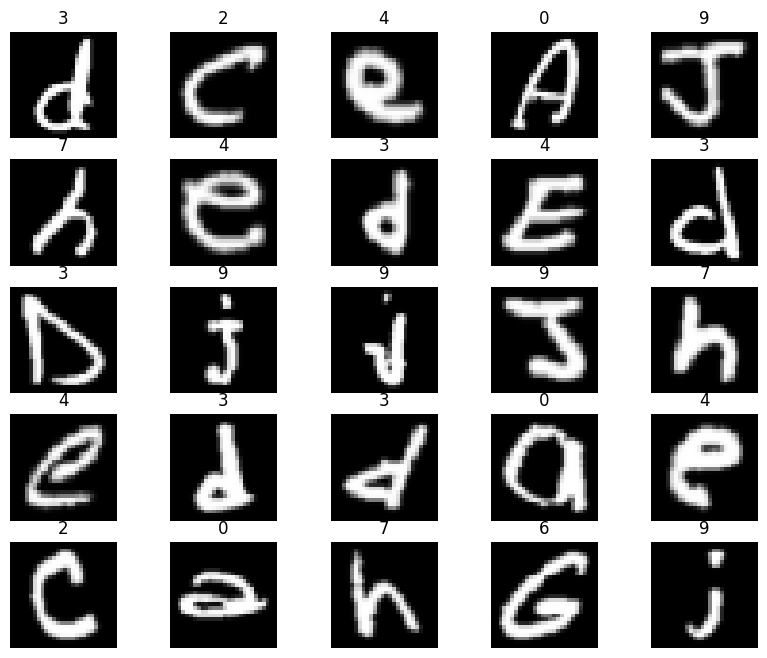

Returning test accuracy list


[0.95725]

In [ ]:
test_and_show(sscnn_sa, loaders, text=False, graph_mode=2, rotate=True)

###Loop

####Initialise

In [ ]:
accuracy_list_sa = []

for i in np.arange(0,trials):
  print("Epoch " + str(i+1))
  epoch_accuracy_list_sa = []

  sscnn_sa = SSCNN(outc = outchannels, out_class = outclass, adapt = 1, softmax = 0, padding = 0)
  loss_func_sscnn_sa = nn.CrossEntropyLoss()
  optimizer_sscnn_sa = optim.SGD(sscnn_sa.parameters(), lr = learning_rate_1)
  print("SSCNN Outc: ", sscnn_sa.outc)
  print("SSCNN Padding: ", sscnn_sa.padding)
  print("SSCNN Outclass: ", sscnn_sa.out_class)
  print("SSCNN Adapt: ", sscnn_sa.adapt)
  print(sscnn_sa)
  copy_sscnn_for_sa = copy.deepcopy(sscnn_base)
  copy_sscnn_for_sa.train()

  load_state_dict_conv_layer(sscnn_sa, copy_sscnn_for_sa.state_dict())

  # print(sscnn_sa.state_dict()['conv1.weight'][0:1])
  # print(sscnn_sa.conv1)
  # print(f"For conv1.weight: {torch.allclose(sscnn_sa.state_dict()['conv1.weight'],sscnn_sa.state_dict()['conv1.weight'])}")

  for param in sscnn_sa.conv1.parameters():
    # print(param)
    # print("Train (Grad)?:", param.requires_grad)
    param.requires_grad = False
    # print("Train (Grad)?:", param.requires_grad)

  print("Debugging\n")
  print("Testing conv1 (is updated and false grad)\n")

  print("Name\t\t Training?\t Not Trained? (Values close?)")

  for named_param in sscnn_base.named_parameters():
    for named_param2 in sscnn_sa.named_parameters():
      if(named_param[0] == named_param2[0]):
        print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
        if(named_param[1].shape == named_param2[1].shape):
          print("\t\t",torch.allclose(named_param[1], named_param2[1]))
        else:
          print("\t\t Size's do not match for ", named_param2[0])

  print("Training sscnn_sa_1to9")
  copy_sscnn_sa = copy.deepcopy(sscnn_sa)
  epoch_accuracy_list_sa = train_with_accuracy(num_epochs, sscnn_sa, loaders, optimizer_sscnn_sa, loss_func_sscnn_sa)
  accuracy_list_sa.append(epoch_accuracy_list_sa)
  print("")
  print("Test sameness of SA sscnn before training to after training")
  check_network(sscnn_sa, copy_sscnn_sa)
  print("")
  print("Test sameness of ssccn to serial adapter sscnn")
  check_network(sscnn_sa, sscnn_base)

print(accuracy_list_sa)

Epoch 1
SSCNN Outc:  6
SSCNN Padding:  0
SSCNN Outclass:  10
SSCNN Adapt:  1
SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=864, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)
Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 Size's do not match for  fc.weight
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias
Training sscnn_sa_1to

####Train

In [ ]:
# print(len(accuracy_list_sa))
# print(len(accuracy_list_sa[0]))

print("Epoch,",end="")
for i in np.arange(0,len(accuracy_list_sa)):
  print("Trial "+str(i+1)+",",end="")
print("mean")

for i in np.arange(0,len(accuracy_list_sa[i])): #5
  sum = 0
  print(str(i+1) + ",",end="")
  for j in np.arange(0,len(accuracy_list_sa)): #3
    # print("i+j: ",i,j, end=": ")
    sum = sum + accuracy_list_sa[j][i][0]*100

    if(j < len(accuracy_list_sa)-1):
      print(str(accuracy_list_sa[j][i][0]*100) + ",",end="")
    else:
      print(str(accuracy_list_sa[j][i][0]*100) + ",",end="")
      print(str(sum/len(accuracy_list_sa)))


Epoch,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean
1,92.675,90.4375,92.0625,92.55,92.7375,92.575,92.7875,92.1875,92.83749999999999,93.0875,92.39375
2,92.65,94.4125,92.2625,93.85,94.075,93.30000000000001,93.66250000000001,92.9875,94.075,94.27499999999999,93.55499999999999
3,94.65,94.1,94.925,94.3125,93.85,94.45,94.4875,94.5125,93.95,94.5,94.37375
4,93.4375,94.95,94.45,94.8,95.6125,94.475,94.22500000000001,95.22500000000001,95.33749999999999,94.6875,94.72
5,95.42500000000001,95.33749999999999,95.075,94.9375,94.975,94.8,95.39999999999999,94.6875,94.4125,95.1,95.015
6,95.3125,95.1375,95.0625,94.66250000000001,95.375,95.42500000000001,94.7125,95.5625,95.4875,95.16250000000001,95.19
7,95.5,95.8125,95.65,93.625,95.625,94.9125,95.8125,95.55,95.0875,95.22500000000001,95.28
8,95.5,95.5125,95.5875,94.675,95.3625,94.925,95.22500000000001,94.55,95.8875,95.4375,95.26625
9,95.375,95.8125,95.19999999999999,95.7,95.7,95.1875,95.25,95.9875,95.95,95.625,95.5787499

####Accuracy

In [ ]:
# test(sscnn_sa_1to9, loaders)
test_and_show(sscnn_sa, loaders, text=False, graph_mode=0, rotate=False)

C: 7655, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7655 : 95.6875
Returning test accuracy list


[0.956875]

C: 7655, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7655 : 95.6875
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([13, 18,  7,  6,  5,  6, 13, 12,  9, 11])) 100 100


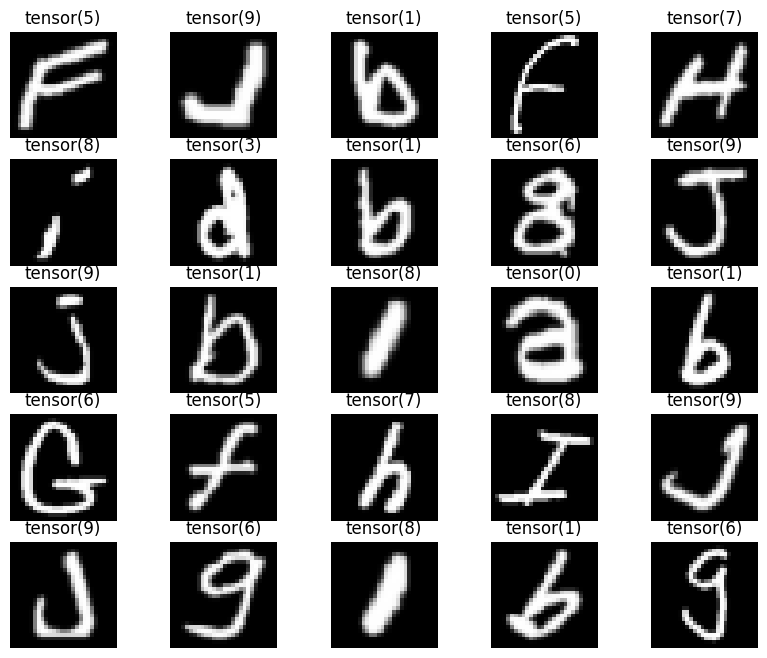

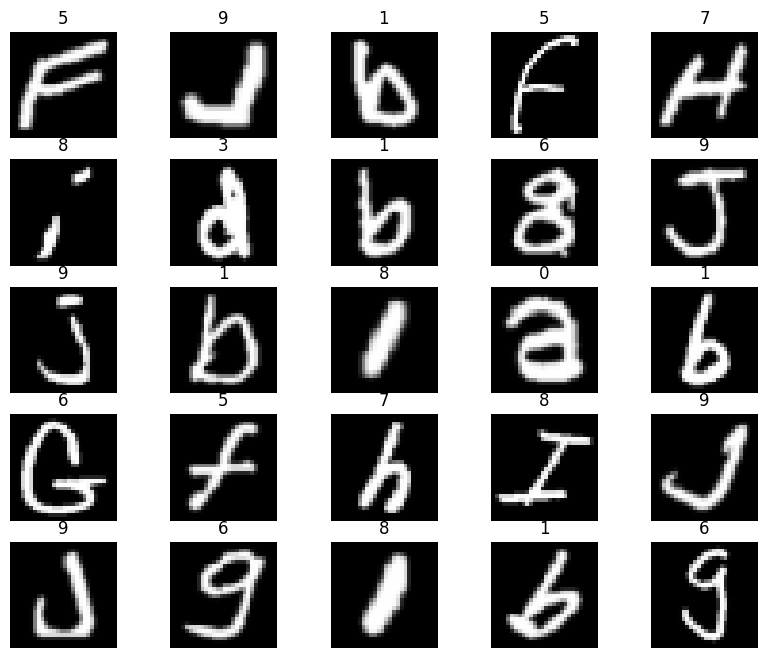

Returning test accuracy list


[0.956875]

In [ ]:
test_and_show(sscnn_sa, loaders, text=False, graph_mode=2, rotate=True)

##SSCNN_PA

###Initialise and Train

####Initialise

In [ ]:
sscnn_pa = SSCNN(outc = outchannels, out_class = outclass, adapt = 2, softmax = 0, padding = 2)
loss_func_sscnn_pa = nn.CrossEntropyLoss()
optimizer_sscnn_pa = optim.SGD(sscnn_pa.parameters(), lr = learning_rate_1)
print("SSCNN Outc: ", sscnn_pa.outc)
print("SSCNN Padding: ", sscnn_pa.padding)
print("SSCNN Outclass: ", sscnn_pa.out_class)
print("SSCNN Adapt: ", sscnn_pa.adapt)

SSCNN Outc:  6
SSCNN Padding:  2
SSCNN Outclass:  10
SSCNN Adapt:  2


In [ ]:
print(sscnn_pa)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
copy_sscnn_for_pa = copy.deepcopy(sscnn_base)
copy_sscnn_for_pa.train()

load_state_dict_conv_layer(sscnn_pa, copy_sscnn_for_pa.state_dict())

# print(sscnn_pa.state_dict()['conv1.weight'][0:1])
# print(sscnn_pa.conv1)
# print(f"For conv1.weight: {torch.allclose(sscnn_base.state_dict()['conv1.weight'],sscnn_pa.state_dict()['conv1.weight'])}")

for param in sscnn_pa.conv1.parameters():
  # print(param)
  # print("Train (Grad)?:", param.requires_grad)
  param.requires_grad = False
  # print("Train (Grad)?:", param.requires_grad)


In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Name\t\t Training?\t Not Trained? (Values close?)")

for named_param in sscnn_base.named_parameters():
  for named_param2 in sscnn_pa.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias


####Train

In [ ]:
print("Training sscnn_pa_1to9")

copy_sscnn_pa = copy.deepcopy(sscnn_pa)
train_with_accuracy(num_epochs, sscnn_pa, loaders, optimizer_sscnn_pa, loss_func_sscnn_pa)
check_network(sscnn_pa, copy_sscnn_pa)

print("")
print("Test sameness of SA sscnn before training to after training")
check_network(sscnn_pa, copy_sscnn_pa)
print("")
print("Test sameness of ssccn to serial adapter sscnn")
check_network(sscnn_pa, sscnn_base)

Training sscnn_pa_1to9

Training beginning

Epoch [1/15], Step [480/480], Loss: 0.36
C: 6539, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 6539 : 81.7375
Returning test accuracy list

Epoch [2/15], Step [480/480], Loss: 0.35
C: 6750, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 6750 : 84.375
Returning test accuracy list

Epoch [3/15], Step [480/480], Loss: 0.52
C: 6736, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 6736 : 84.2
Returning test accuracy list

Epoch [4/15], Step [480/480], Loss: 0.42
C: 6832, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 6832 : 85.39999999999999
Returning test accuracy list

Epoch [5/15], Step [480/480], Loss: 0.36
C: 6787, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 6787 : 84.8375
Returning test accuracy list

Epoch [6/15], Step [480/480], Loss: 0.38
C: 6843, T: 8000, A: 0
Test Accuracy of the model on the 80

####Accuracy

In [ ]:
# test(sscnn_pa_1to9, loaders)
test_and_show(sscnn_pa, loaders, text=False, graph_mode=0, rotate=False)

C: 7651, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7651 : 95.6375
Returning test accuracy list


[0.956375]

C: 7651, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7651 : 95.6375
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([ 8,  9, 10,  5, 10, 13,  9,  8, 14, 14])) 100 100


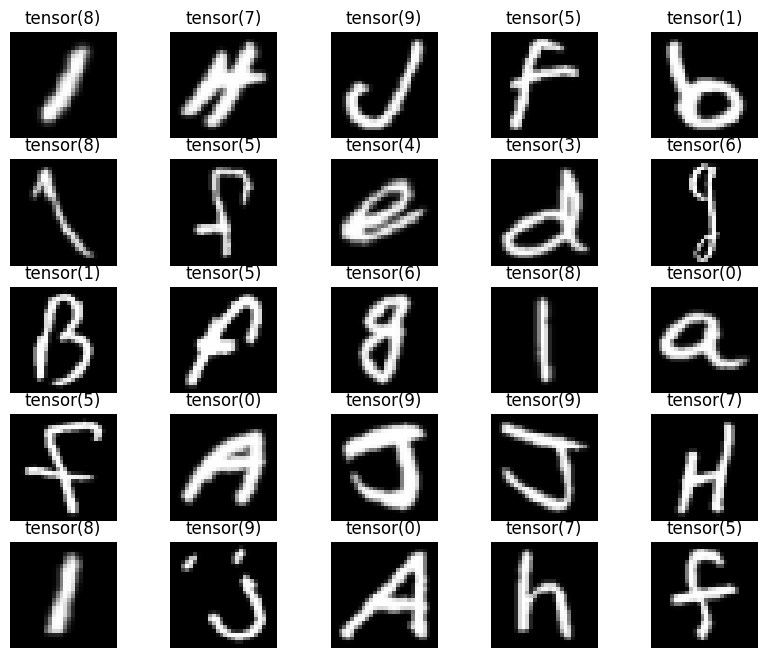

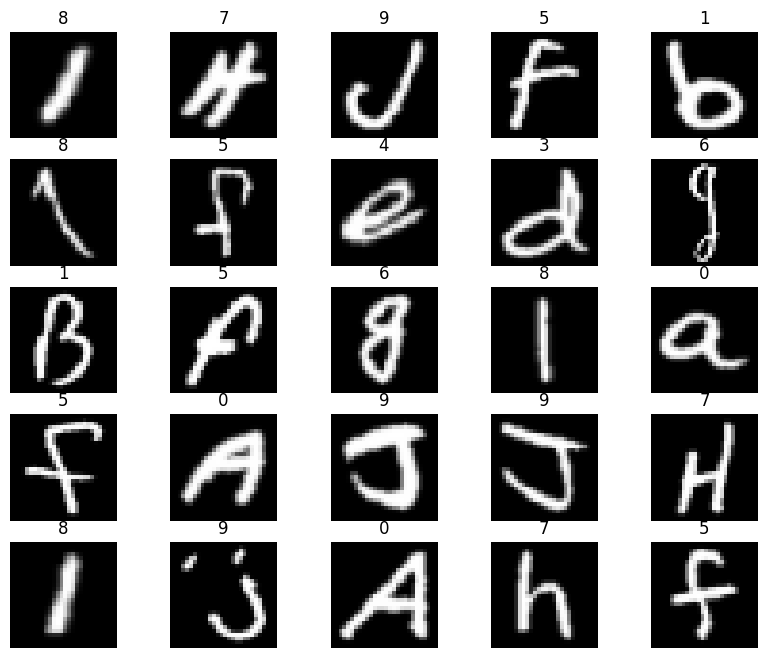

Returning test accuracy list


[0.956375]

In [ ]:
test_and_show(sscnn_pa, loaders, text=False, graph_mode=2, rotate=True)

###Loop

####Initialise

In [ ]:
accuracy_list_pa = []

for i in np.arange(0,trials):
  print("Epoch " + str(i+1))
  epoch_accuracy_list_pa = []

  sscnn_pa = SSCNN(outc = outchannels, out_class = outclass, adapt = 2, softmax = 0, padding = 2)
  loss_func_sscnn_pa = nn.CrossEntropyLoss()
  optimizer_sscnn_pa = optim.SGD(sscnn_pa.parameters(), lr = learning_rate_1)
  print("SSCNN Outc: ", sscnn_pa.outc)
  print("SSCNN Padding: ", sscnn_pa.padding)
  print("SSCNN Outclass: ", sscnn_pa.out_class)
  print("SSCNN Adapt: ", sscnn_pa.adapt)
  print(sscnn_pa)
  copy_sscnn_for_pa = copy.deepcopy(sscnn_base)
  copy_sscnn_for_pa.train()

  load_state_dict_conv_layer(sscnn_pa, copy_sscnn_for_pa.state_dict())

  # print(sscnn_pa.state_dict()['conv1.weight'][0:1])
  # print(sscnn_pa.conv1)
  # print(f"For conv1.weight: {torch.allclose(sscnn_pa.state_dict()['conv1.weight'],sscnn_pa.state_dict()['conv1.weight'])}")

  for param in sscnn_pa.conv1.parameters():
    # print(param)
    # print("Train (Grad)?:", param.requires_grad)
    param.requires_grad = False
    # print("Train (Grad)?:", param.requires_grad)

  print("Debugging\n")
  print("Testing conv1 (is updated and false grad)\n")

  print("Name\t\t Training?\t Not Trained? (Values close?)")

  for named_param in sscnn_base.named_parameters():
    for named_param2 in sscnn_pa.named_parameters():
      if(named_param[0] == named_param2[0]):
        print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
        if(named_param[1].shape == named_param2[1].shape):
          print("\t\t",torch.allclose(named_param[1], named_param2[1]))
        else:
          print("\t\t Size's do not match for ", named_param2[0])

  print("Training sscnn_pa")
  copy_sscnn_pa = copy.deepcopy(sscnn_pa)
  epoch_accuracy_list_pa = train_with_accuracy(num_epochs, sscnn_pa, loaders, optimizer_sscnn_pa, loss_func_sscnn_pa)
  accuracy_list_pa.append(epoch_accuracy_list_pa)
  print("")
  print("Test sameness of PA sscnn before training to after training")
  check_network(sscnn_pa, copy_sscnn_pa)
  print("")
  print("Test sameness of ssccn to parallel adapter sscnn")
  check_network(sscnn_pa, sscnn_base)

print(accuracy_list_pa)

Epoch 1
SSCNN Outc:  6
SSCNN Padding:  2
SSCNN Outclass:  10
SSCNN Adapt:  2
SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)
Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 False 		 True
conv1.bias 	 False 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias
Training sscnn_pa

Training begin

####Train

In [ ]:
print("Epoch,",end="")
for i in np.arange(0,len(accuracy_list_pa)):
  print("Trial "+str(i+1)+",",end="")
print("mean")

for i in np.arange(0,len(accuracy_list_pa[i])): #5
  sum = 0
  print(str(i+1) + ",",end="")
  for j in np.arange(0,len(accuracy_list_pa)): #3
    # print("i+j: ",i,j, end=": ")
    sum = sum + accuracy_list_pa[j][i][0]*100

    if(j < len(accuracy_list_pa)-1):
      print(str(accuracy_list_pa[j][i][0]*100) + ",",end="")
    else:
      print(str(accuracy_list_pa[j][i][0]*100) + ",",end="")
      print(str(sum/len(accuracy_list_pa)))


Epoch,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean
1,92.3875,92.2375,91.6125,91.6125,91.95,90.73750000000001,91.7,82.7375,90.71249999999999,91.5625,90.725
2,93.4625,93.7875,93.7375,94.45,93.10000000000001,92.8625,93.13749999999999,84.1875,94.1875,94.05,92.69624999999999
3,94.65,93.83749999999999,94.8,94.9625,94.4875,94.35,94.16250000000001,84.7125,94.7625,94.0875,93.48125
4,95.075,94.77499999999999,94.3,94.69999999999999,95.325,94.4125,94.6875,85.2,95.1125,94.875,93.84625
5,95.0,94.4625,95.0875,95.5375,94.7625,95.0,95.35,85.7625,94.925,95.025,94.09124999999999
6,95.4125,95.0,95.4125,95.2375,94.575,95.0125,95.1875,85.775,94.86250000000001,95.4875,94.19624999999999
7,95.3625,95.1875,94.95,95.1125,95.5375,94.9125,95.46249999999999,85.7625,95.4375,94.7375,94.24625
8,95.75,95.275,95.78750000000001,95.5875,95.6,95.25,95.4125,85.5125,95.5,95.1,94.4775
9,95.5125,95.1375,95.75,95.375,95.6875,95.5625,95.65,86.225,95.2125,95.7,94.58125
10,95.5125,95.15,95.

####Accuracy

In [ ]:
# test(sscnn_sa_1to9, loaders)
test_and_show(sscnn_pa, loaders, text=False, graph_mode=0, rotate=False)

C: 7659, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7659 : 95.7375
Returning test accuracy list


[0.957375]

C: 7659, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7659 : 95.7375
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([14, 11, 10,  6,  7,  7, 13, 16, 10,  6])) 100 100


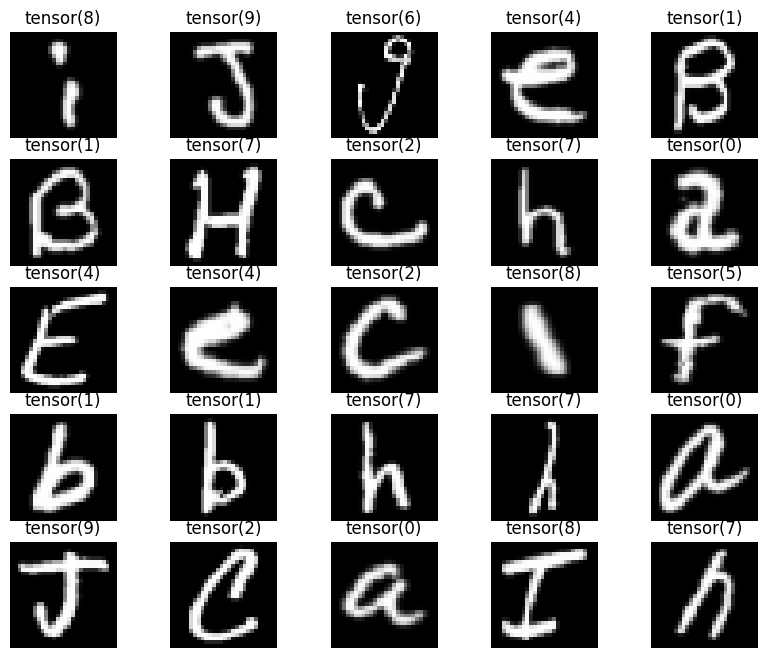

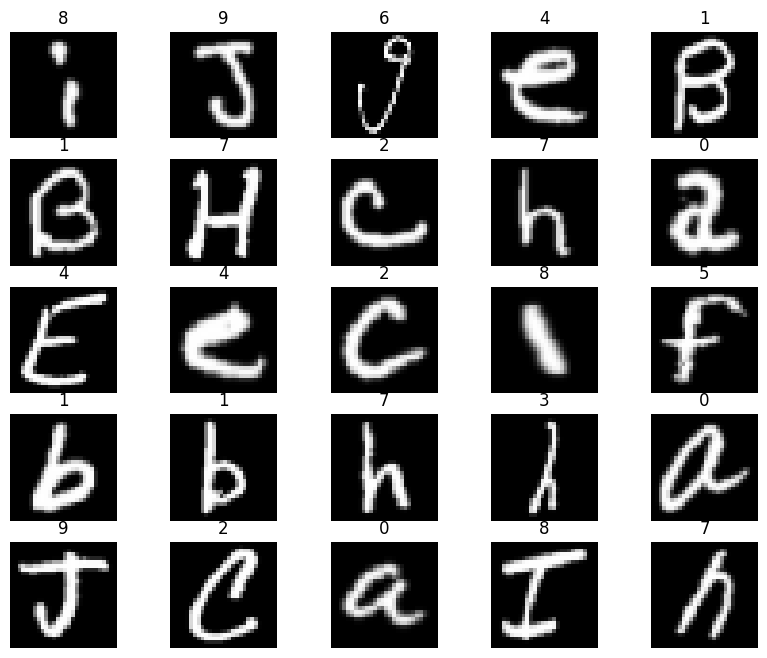

Returning test accuracy list


[0.957375]

In [ ]:
test_and_show(sscnn_pa, loaders, text=False, graph_mode=2, rotate=True)

##SSCNN_FT

###Initialise and Train

####Initialise

In [ ]:
sscnn_ft = SSCNN(outc = outchannels_1to9, out_class = 10, adapt = 0, softmax = 0, padding = 2)
loss_func_sscnn_ft = nn.CrossEntropyLoss()
optimizer_sscnn_ft = optim.SGD(sscnn_ft.parameters(), lr = learning_rate_1)
print("SSCNN Outc: ", sscnn_ft.outc)
print("SSCNN Outclass: ", sscnn_ft.out_class)
print("SSCNN Adapt: ", sscnn_ft.adapt)

SSCNN Outc:  6
SSCNN Outclass:  10
SSCNN Adapt:  0


In [ ]:
print(sscnn_ft)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


In [ ]:
copy_sscnn_for_ft = copy.deepcopy(sscnn_base)
copy_sscnn_for_ft.train()

# load_state_dict_ft(sscnn_ft, copy_sscnn_for_ft.state_dict())
load_state_dict_conv_layer(sscnn_ft, copy_sscnn_for_ft.state_dict())


# for param in copy_sscnn_1to9_for_ft.state_dict():
#   print(param, " contains ", copy_sscnn_1to9_for_ft.state_dict()[param])
#   if param == "conv1.weight":
#     sscnn_1to9_for_ft.state_dict()[param] = copy_sscnn_1to9_for_ft.state_dict()[param];




In [ ]:
print("Debugging\n")
print("Testing conv1 (is updated and false grad)\n")

print("Name\t\t Training?\t Not Trained? (Values close?)")

for named_param in sscnn_base.named_parameters():
  for named_param2 in sscnn_ft.named_parameters():
    if(named_param[0] == named_param2[0]):
      print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
      if(named_param[1].shape == named_param2[1].shape):
        print("\t\t",torch.allclose(named_param[1], named_param2[1]))
      else:
        print("\t\t Size's do not match for ", named_param2[0])

Debugging

Testing conv1 (is updated and false grad)

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 True 		 True
conv1.bias 	 True 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias


In [ ]:
print(sscnn_ft)

SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)


####Train

In [ ]:
print("sscnn_ft")

copy_sscnn_1to9_ft = copy.deepcopy(sscnn_ft)
train_with_accuracy(num_epochs, sscnn_ft, loaders, optimizer_sscnn_ft, loss_func_sscnn_ft)
check_network(sscnn_ft, copy_sscnn_1to9_ft)

sscnn_ft

Training beginning

Epoch [1/15], Step [480/480], Loss: 0.12
C: 7425, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7425 : 92.8125
Returning test accuracy list

Epoch [2/15], Step [480/480], Loss: 0.19
C: 7503, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7503 : 93.7875
Returning test accuracy list

Epoch [3/15], Step [480/480], Loss: 0.11
C: 7591, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7591 : 94.8875
Returning test accuracy list

Epoch [4/15], Step [480/480], Loss: 0.17
C: 7614, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7614 : 95.175
Returning test accuracy list

Epoch [5/15], Step [480/480], Loss: 0.12
C: 7636, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7636 : 95.45
Returning test accuracy list

Epoch [6/15], Step [480/480], Loss: 0.05
C: 7658, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct

In [ ]:
check_network(sscnn_ft, copy_sscnn_1to9_ft)
check_network(sscnn_ft, sscnn_base)

for named_param in sscnn_base.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

for named_param in sscnn_ft.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNNft: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNNft Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

False is same for conv1.weight
False is same for conv1.bias
True is same for conv1sa.weight
True is same for conv1sa.bias
True is same for conv1pa.weight
True is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
False is same for out.weight
False is same for out.bias
False is same for conv1.weight
False is same for conv1.bias
False is same for conv1sa.weight
False is same for conv1sa.bias
False is same for conv1pa.weight
False is same for conv1pa.bias
False is same for fc.weight
False is same for fc.bias
Shapes do not match for out.weight and out.weight
Shapes do not match for out.bias and out.bias

SSCNN:  conv1.weight tensor([[ 0.2982,  0.1764,  0.0157, -0.1633, -0.3611],
        [-0.1594, -0.0424,  0.3110,  0.1388, -0.4448],
        [ 0.0227, -0.0858,  0.1397,  0.4910,  0.1573],
        [-0.1969, -0.1107, -0.0570,  0.1190,  0.4604],
        [-0.2211, -0.2909, -0.3192, -0.2600,  0.3774]],
       grad_fn=<SelectBackward0>) True

SSCNN Others:  fc.weight tenso

####Accuracy

In [ ]:
# test(sscnn_pa_1to9, loaders)
test_and_show(sscnn_ft, loaders, text=False, graph_mode=0, rotate=False)

C: 7717, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7717 : 96.46249999999999
Returning test accuracy list


[0.964625]

C: 7717, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7717 : 96.46249999999999
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([12,  9, 13,  8, 10, 12, 10,  8, 11,  7])) 100 100


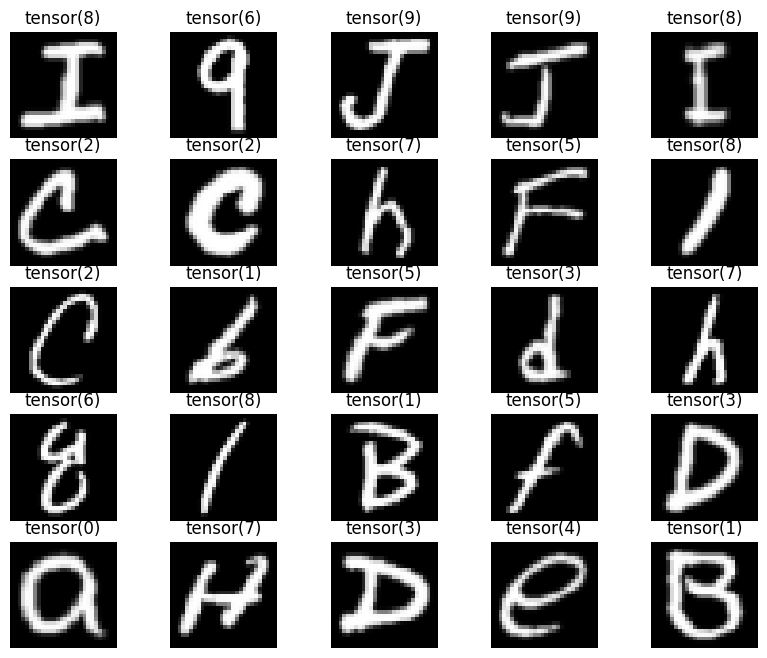

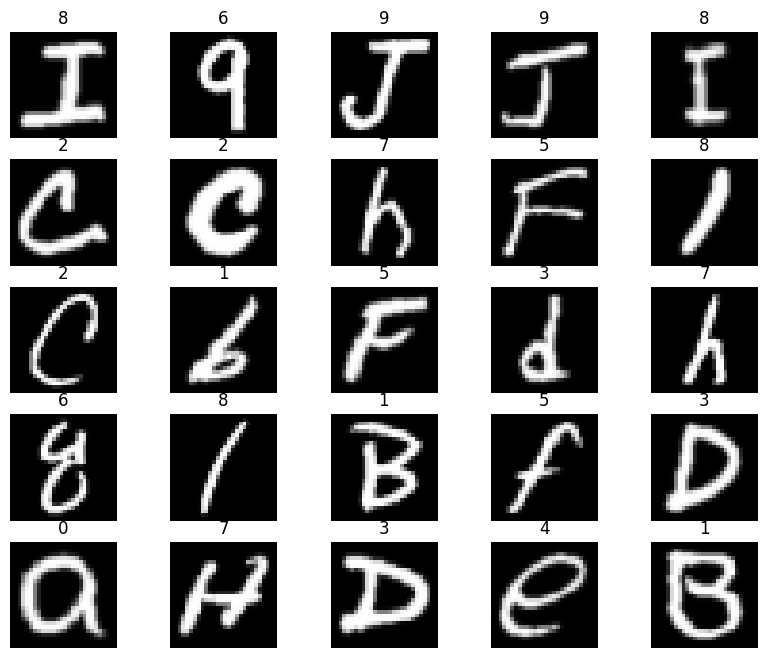

P: 8 A: 8 T: True
P: 6 A: 6 T: True
P: 9 A: 9 T: True
Nine True
P: 9 A: 9 T: True
Nine True
P: 8 A: 8 T: True
P: 2 A: 2 T: True
P: 2 A: 2 T: True
P: 7 A: 7 T: True
P: 5 A: 5 T: True
P: 8 A: 8 T: True
P: 2 A: 2 T: True
P: 1 A: 1 T: True
P: 5 A: 5 T: True
P: 3 A: 3 T: True
P: 7 A: 7 T: True
P: 6 A: 6 T: True
P: 8 A: 8 T: True
P: 1 A: 1 T: True
P: 5 A: 5 T: True
P: 3 A: 3 T: True
P: 0 A: 0 T: True
Zero True
P: 7 A: 7 T: True
P: 3 A: 3 T: True
P: 4 A: 4 T: True
P: 1 A: 1 T: True
Class nine detected
Returning test accuracy list


[0.964625]

In [ ]:
test_and_show(sscnn_ft, loaders, text=True, graph_mode=2, rotate=True)

In [ ]:
for named_param in sscnn_base.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      print("\nSSCNN Others: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)

    # else:
      # print("\nSSCNN Others: ", named_param[0], named_param[1], named_param[1].requires_grad)

for named_param in sscnn_ft.named_parameters():
    if named_param[0] == 'conv1.weight':
      print("\nSSCNN ft: ", named_param[0], named_param[1][0][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1sa.weight':
      print("\nSSCNN ft: ", named_param[0], named_param[1][0], named_param[1].requires_grad)
    elif named_param[0] == 'conv1pa.weight' :
      print("\nSSCNN ft: ", named_param[0], named_param[1], named_param[1].requires_grad)
    elif named_param[0] == 'fc.weight' or named_param[0] == 'out.weight':
      torch.set_printoptions(precision=10)
      print("\nSSCNN ft Others: ", named_param[0], named_param[1][0][0:5], named_param[1].requires_grad)
      torch.set_printoptions(precision=4)

      # else:
      # print("\nSSCNNpA Others: ", named_param[0], named_param[1], named_param[1].requires_grad)


SSCNN:  conv1.weight tensor([[ 0.2982,  0.1764,  0.0157, -0.1633, -0.3611],
        [-0.1594, -0.0424,  0.3110,  0.1388, -0.4448],
        [ 0.0227, -0.0858,  0.1397,  0.4910,  0.1573],
        [-0.1969, -0.1107, -0.0570,  0.1190,  0.4604],
        [-0.2211, -0.2909, -0.3192, -0.2600,  0.3774]],
       grad_fn=<SelectBackward0>) True

SSCNN:  conv1sa.weight tensor([[[ 0.0490]],

        [[-0.3644]],

        [[-0.1038]],

        [[-0.1167]],

        [[ 0.0319]],

        [[-0.3691]]], grad_fn=<SelectBackward0>) True

SSCNN:  conv1pa.weight Parameter containing:
tensor([[[[ 0.9597]]],


        [[[-0.5799]]],


        [[[ 0.9396]]],


        [[[-0.6509]]],


        [[[-0.6938]]],


        [[[-0.2299]]]], requires_grad=True) True

SSCNN Others:  fc.weight tensor(0.0094, grad_fn=<SelectBackward0>) True

SSCNN Others:  out.weight tensor(-0.0387, grad_fn=<SelectBackward0>) True

SSCNN ft:  conv1.weight tensor([[ 0.3739,  0.4183,  0.2816, -0.2757, -0.8559],
        [-0.3089,  0.1059, 

###Loop

####Initialise

In [ ]:
accuracy_list_ft = []

for i in np.arange(0,trials):
  print("Epoch " + str(i+1))
  epoch_accuracy_list_ft = []

  sscnn_ft = SSCNN(outc = outchannels, out_class = outclass, adapt = 0, softmax = 0, padding = 2)
  loss_func_sscnn_ft = nn.CrossEntropyLoss()
  optimizer_sscnn_ft = optim.SGD(sscnn_ft.parameters(), lr = learning_rate_1)
  print("SSCNN Outc: ", sscnn_ft.outc)
  print("SSCNN Padding: ", sscnn_ft.padding)
  print("SSCNN Outclass: ", sscnn_ft.out_class)
  print("SSCNN Adapt: ", sscnn_ft.adapt)
  print(sscnn_ft)
  copy_sscnn_for_ft = copy.deepcopy(sscnn_base)
  copy_sscnn_for_ft.train()

  # load_state_dict_ft(sscnn_ft, copy_sscnn_for_ft.state_dict())
  load_state_dict_conv_layer(sscnn_ft, copy_sscnn_for_ft.state_dict())

  # print(sscnn_ft.state_dict()['conv1.weight'][0:1])
  # print(sscnn_ft.conv1)
  # print(f"For conv1.weight: {torch.allclose(sscnn_ft.state_dict()['conv1.weight'],sscnn_ft.state_dict()['conv1.weight'])}")

  print("Debugging\n")
  print("Testing conv1 (is updated and true grad\n")

  print("Name\t\t Training?\t Not Trained? (Values close?)")

  for named_param in sscnn_base.named_parameters():
    for named_param2 in sscnn_ft.named_parameters():
      if(named_param[0] == named_param2[0]):
        print(named_param2[0],"\t", named_param2[1].requires_grad, end = " ")
        if(named_param[1].shape == named_param2[1].shape):
          print("\t\t",torch.allclose(named_param[1], named_param2[1]))
        else:
          print("\t\t Size's do not match for ", named_param2[0])

  print("Training sscnn_ft")
  copy_sscnn_ft = copy.deepcopy(sscnn_ft)
  epoch_accuracy_list_ft = train_with_accuracy(num_epochs, sscnn_ft, loaders, optimizer_sscnn_ft, loss_func_sscnn_ft)
  accuracy_list_ft.append(epoch_accuracy_list_ft)
  print("")
  print("Test sameness of FT sscnn before training to after training")
  check_network(sscnn_ft, copy_sscnn_ft)
  print("")
  print("Test sameness of ssccn to ft sscnn")
  check_network(sscnn_ft, sscnn_base)

print(accuracy_list_ft)

Epoch 1
SSCNN Outc:  6
SSCNN Padding:  2
SSCNN Outclass:  10
SSCNN Adapt:  0
SSCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1sa): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1))
  (conv1pa): Conv2d(1, 6, kernel_size=(1, 1), stride=(1, 1))
  (actv): ReLU()
  (out_actv): Sigmoid()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=1176, out_features=45, bias=True)
  (out): Linear(in_features=45, out_features=10, bias=True)
)
Debugging

Testing conv1 (is updated and true grad

Name		 Training?	 Not Trained? (Values close?)
conv1.weight 	 True 		 True
conv1.bias 	 True 		 True
conv1sa.weight 	 True 		 False
conv1sa.bias 	 True 		 False
conv1pa.weight 	 True 		 False
conv1pa.bias 	 True 		 False
fc.weight 	 True 		 False
fc.bias 	 True 		 False
out.weight 	 True 		 Size's do not match for  out.weight
out.bias 	 True 		 Size's do not match for  out.bias
Training sscnn_ft

Training beginning

####Train

In [ ]:
print("Epoch,",end="")
for i in np.arange(0,len(accuracy_list_ft)):
  print("Trial "+str(i+1)+",",end="")
print("mean")

for i in np.arange(0,len(accuracy_list_ft[i])): #5
  sum = 0
  print(str(i+1) + ",",end="")
  for j in np.arange(0,len(accuracy_list_ft)): #3
    # print("i+j: ",i,j, end=": ")
    sum = sum + accuracy_list_ft[j][i][0]*100

    if(j < len(accuracy_list_ft)-1):
      print(str(accuracy_list_ft[j][i][0]*100) + ",",end="")
    else:
      print(str(accuracy_list_ft[j][i][0]*100) + ",",end="")
      print(str(sum/len(accuracy_list_ft)))


Epoch,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10,mean
1,92.9125,92.6125,93.0,92.5375,82.075,91.525,92.2625,92.72500000000001,93.22500000000001,92.95,91.58250000000001
2,93.8875,92.875,94.575,93.89999999999999,84.25,93.875,94.25,93.5375,93.7125,94.5875,92.945
3,94.925,95.2375,95.28750000000001,94.2375,85.41250000000001,94.575,94.85,94.6125,95.05,95.1875,93.9375
4,94.025,95.3875,94.925,94.77499999999999,86.1875,95.33749999999999,95.0375,95.0125,94.3875,95.1,94.01750000000001
5,94.8875,95.45,95.76249999999999,95.1375,95.42500000000001,95.3,95.45,95.2375,95.35,95.475,95.3475
6,95.72500000000001,95.6375,95.575,95.1875,95.5125,95.8125,95.4875,95.4125,95.6,95.7375,95.56875
7,95.6125,95.75,95.6875,95.5,95.65,95.5,95.25,95.5875,95.6,95.125,95.52625
8,95.625,95.6375,95.825,95.9125,95.85000000000001,95.6625,95.35,95.89999999999999,95.85000000000001,95.76249999999999,95.7375
9,95.875,95.9375,95.95,95.5125,95.8,95.45,95.6875,95.9125,95.89999999999999,95.5625,95

####Accuracy

In [ ]:
# test(sscnn_sa_1to9, loaders)
test_and_show(sscnn_ft, loaders, text=False, graph_mode=0, rotate=False)

C: 7697, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7697 : 96.2125
Returning test accuracy list


[0.962125]

C: 7697, T: 8000, A: 0
Test Accuracy of the model on the 8000 test images. Correct: 7697 : 96.2125
Targets:  (tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), tensor([12, 13, 15, 10, 10, 11,  9,  4,  8,  8])) 100 100


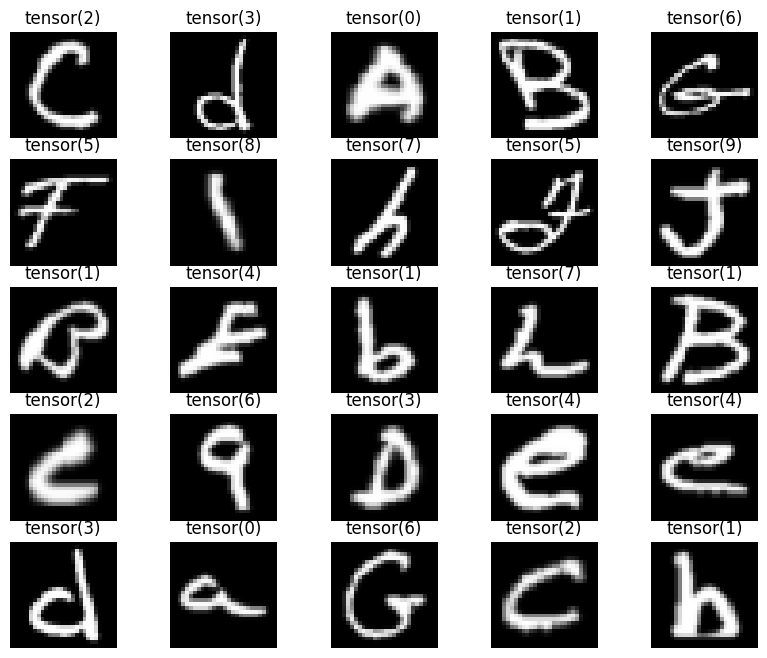

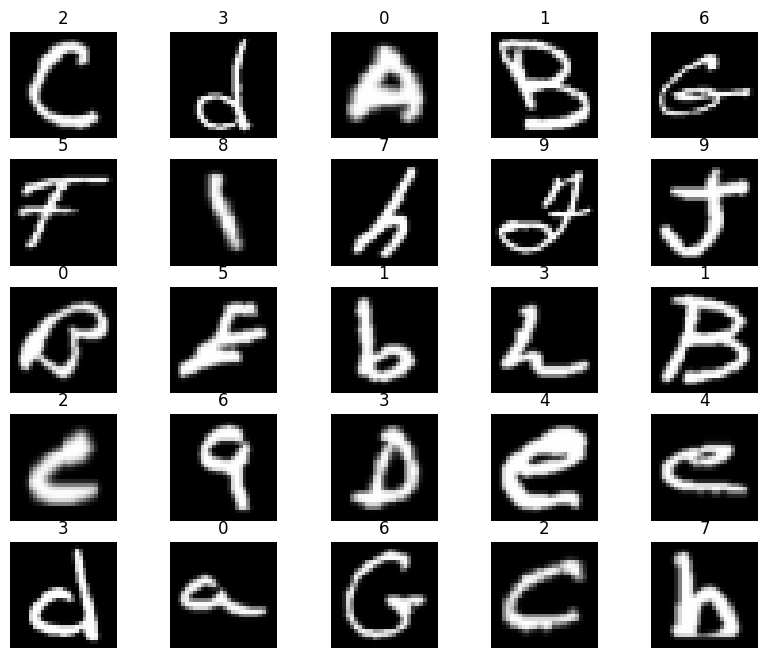

Returning test accuracy list


[0.962125]

In [ ]:
test_and_show(sscnn_ft, loaders, text=False, graph_mode=2, rotate=True)

In [ ]:
print(sscnn_ft.conv1.weights)

AttributeError: ignored

#Files Generator

C# code for parsing MNIST
https://www.clounce.com/dotnet/fun-with-mnist-dataset

In [ ]:
downloadFiles = downloadFilesGlobal

import torch
from torch import optim

#Might be redundant
from torchvision import datasets
import torchvision.datasets as datasets

from torchvision.transforms import ToTensor
from torchvision.transforms import v2

from torch.utils.data import DataLoader
from torch.utils.data import Subset

import torch.nn as nn

from torch.autograd import Variable

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import numpy as np

import struct
import binascii

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [ ]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

###Show Data

In [ ]:
fshowdata = 1
if fshowdata == 1:

  print("MNIST Train\n\n")

  print("Train data: ", train_data)
  print("Test data: ", test_data)
  print("Train data size: ", train_data.data.size())
  print("Test data size: ", test_data.data.size())
  print("Train example 6th row: ", train_data[0][0][0][5])
  print("Test example 5: ", train_data.targets[0])

  plt.imshow(train_data.data[0], cmap='gray')
  plt.title('%i' % train_data.targets[0])
  plt.show()

  print("Targets[1:10]: ", train_data.targets[1:10])

  # figure = plt.figure(figsize=(10, 8))
  # cols, rows = 5, 5
  # for i in range(1, cols * rows + 1):

  #     # sample_idx = torch.randint(len(train_data), size=(1,)).item()

  #     img, label = train_data[i]

  #     figure.add_subplot(rows, cols, i)
  #     plt.title(f'Class: {label}')
  #     plt.axis("off")

  #     plt.imshow(img.squeeze(), cmap="gray")

  # plt.show()

### Format Data for generation

In [ ]:
!pip install idx2numpy

In [ ]:
import idx2numpy
import pandas as pd

In [ ]:
# Files location:
labels_file = 't10k-labels.idx1-ubyte'
images_file = 't10k-images.idx3-ubyte'

# Read data:
labels_data = idx2numpy.convert_from_file("/content/data/MNIST/raw/train-labels-idx1-ubyte")
images_data = idx2numpy.convert_from_file("/content/data/MNIST/raw/train-images-idx3-ubyte")

In [ ]:
# Display number of instances:
print(images_data.shape,labels_data.shape)
n_images, im_size = images_data.shape[:2]
n_labels = labels_data.shape[0]
print(f"There is {n_images} images.")
print(f"There is {n_labels} labels.")
print(f"The images size is {im_size}.")

In [ ]:
#Data

#28 uint8
print((images_data[0][0]))

#28 per row
print(len(images_data[0][0]))

# uint8
print(type(images_data[0][0][0]))

# Convert to hex 'byte' --> 2 char per number = 2 bytes per number
print(binascii.hexlify(images_data[0][0]))

# 56 / 2 = 28
print(len(binascii.hexlify(images_data[0][0])))
print(len(binascii.hexlify(images_data[0][0]))/2)

In [ ]:
print((images_data[0]))
print(binascii.hexlify(images_data[0]))
#28*28*bytes * 2*char/byte = 1568 char
print(len(binascii.hexlify(images_data[0])))
print(len(binascii.hexlify(images_data[0]))/2/28)

In [ ]:
images_data_float32 = images_data.astype(np.float32)
labels_data_float32 = labels_data.astype(np.float32)
print((images_data_float32[0]))
print(binascii.hexlify(images_data_float32[0]))
print((images_data_float32[0][0]))
print(binascii.hexlify(images_data_float32[0][0]))
print(len(binascii.hexlify(images_data_float32[0][0])))
#4bytes per 32bits
print(len(binascii.hexlify(images_data_float32[0][0]))/8)

In [ ]:
# https://gregstoll.com/~gregstoll/floattohex/

# import binascii
import struct

i = 1
a = np.float32(i)
b = np.float32(i+1)
print(a)
print(b)

# def binary(num):
#     return ''.join('{:0>8b}'.format(c) for c in struct.pack('!f', num))

# print(binary(a))

ba = bytearray(struct.pack("f", a))
bb = bytearray(struct.pack("f", b))
print(ba)
print(bb)
print([ "0x%02x" % b for b in ba ])
print([ "0x%02x" % b for b in bb ])

output = str(binascii.hexlify(ba),'ascii')
print(output)

##Visualise Data (for debugging)

In [ ]:
import matplotlib.pyplot as plt

# Display an element:
for i in np.arange(0,10):
  plt.imshow(images_data[i], cmap=plt.cm.binary)
  plt.title(labels_data[i])
  plt.show()

In [ ]:
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000,
    formatter=dict(float=lambda x: "%.3g" % x))

print(images_data[0].shape)
print("")

count = 0
for x in images_data:
  print(x)
  print("")
  count += 1
  if count == 10:
    break

count = 0
print(np.arange(24*28,24*28+28))
for x in images_data:
  print(x[24])
  print("")
  count += 1
  if count == 10:
    break

count = 0
print(np.arange(23*28+9,23*28+10))
for x in images_data:
  print(x[23][9])
  print("")
  print("Label: ", labels_data[count])
  print("")
  count += 1
  if count == 10:
    break

In [ ]:
import gzip
import struct

with gzip.open("/content/data/MNIST/raw/train-images-idx3-ubyte.gz") as f:
  b = f.read(-1)
  print(len(b[0:16]), len(b[8:12]), len(b[16:17]))
  print(b[0:16])
  print(struct.unpack('>IIII', b[0:16]))

  print(struct.unpack('>BB', b[0:2]))
  print("Type (8 is unsigned byte):", struct.unpack('>B', b[2:3]))
  print("Dimensions (60000x28x28): ",struct.unpack('>B', b[3:4]))
  print("Magic number: ",struct.unpack('>I', b[0:4]))
  print("Size: ", struct.unpack('>I', b[4:8]))
  print("Dimension 0: ", struct.unpack('>I', b[8:12]))
  print("Dimension 1: ", struct.unpack('>I', b[12:16]))

  # print(np.arange(20,28+1,1))
  start = 16
  for i in np.arange(start,start+(28*28)*3,1):
    if(((i-start)) % (28*28) == 0):
      print("")
      print("")
      print(f"Row {((i-start)//28):3}:    ",end="")
      v = struct.unpack('>B', b[i:i+1])
      print(f"{v[0]:3}", end=" ")
    elif((i-start) % 28 == 0):
      print("")
      print(f"Row {((i-start)//28):3}:    ",end="")
      v = struct.unpack('>B', b[i:i+1])
      print(f"{v[0]:3}", end=" ")
    else:
      v = struct.unpack('>B', b[i:i+1])
      print(f"{v[0]:3}", end=" ")



##Generate memory files

### Uint8

In [ ]:
import struct
import binascii

def print_mnist_mem(numbers_input_list, filename, download = False):
  with open(filename, "w") as text_file:

  #Print bytes

    print("Input Len : ", len(numbers_input_list))

    for i in np.arange(len(numbers_input_list)):

      width = 2

      # Operate on 0 to end-1 bytes
      start = 0
      end = len(numbers_input_list[i])

      # print("W, S, E : ", width, start, end)

      for j in np.arange(start,end,width):

        output = str(numbers_input_list[i][j:j+width],'ascii')

        if(i == len(numbers_input_list)-1 and j == end-width):
          # print("Last line")
          text_file.write(output)
        else:
          # print(output + "\n",end="")
          text_file.write(output + "\n")

  if(download == True):
    from google.colab import files
    files.download(filename)

  print("W, S, E : ", width, start, end)

In [ ]:
labels_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  # print(binascii.hexlify(labels_data[i]))
  labels_input_list.append(binascii.hexlify(labels_data[i]))

filename = "mnist_labels_hex_uint8_10.mem"

print_mnist_mem(labels_input_list, filename, download = downloadFiles)

image_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  image_input_list.append(binascii.hexlify(images_data[i]))

filename = "mnist_images_hex_uint8_10.mem"

print_mnist_mem(image_input_list, filename, download = downloadFiles)

###Float32 Real

In [ ]:
import struct
import binascii

def print_mnist_mem_real(numbers_input_list, filename, download = False):
  with open(filename, "w") as text_file:

  #Print bytes

    numbers_input_array = np.array(numbers_input_list)
    array_dim = numbers_input_array.ndim

    print("Input Len : ", numbers_input_array.shape[0])

    for i in np.arange(numbers_input_array.shape[0]):

      width = 1

      # # Operate on 0 to end-1 bytes
      start = 0

      if(array_dim == 3):
        # print("Dim is 3, shape is: ", numbers_input_array.shape)
        end = numbers_input_array.shape[1]

        for j in np.arange(start,end,width):
          for k in np.arange(start,end,width):
            output = numbers_input_list[i][j][k]

            if(i == len(numbers_input_list)-1 and j == end-width and k == end-width):
              # print("Last line")
              # print(output)
              text_file.write(str(output))
            else:
              # print(output, "\n")
              # print(output + "\n",end="")
              text_file.write(str(output) + "\n")
      else:

        output = numbers_input_list[i]
        # print(output)

        if(i == len(numbers_input_list)-1):
          text_file.write(str(output))
        else:
          text_file.write(str(output)+"\n")


  if(download == True):
    from google.colab import files
    files.download(filename)


In [ ]:
labels_data_float32_real = labels_data.astype(np.float32)
images_data_float32_real = images_data.astype(np.float32)

labels_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  # print(labels_data_float32_real[i])
  labels_input_list.append(labels_data_float32_real[i])

filename = "mnist_labels_fp32_real_10.mem"

print_mnist_mem_real(labels_input_list, filename, download = downloadFiles)

image_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  # print(images_data_float32_real[i])
  image_input_list.append(images_data_float32_real[i])

filename = "mnist_images_fp32_real_10.mem"

print_mnist_mem_real(image_input_list, filename, download = downloadFiles)

### Float 32 Hexadecimal

####Labels

In [ ]:
import struct
import binascii

def print_mnist_mem_label_float32(numbers_input_list, filename, download = False):
  with open(filename, "w") as text_file:

  #Print bytes

    print("Input Len : ", len(numbers_input_list))

    for i in np.arange(len(numbers_input_list)):

      #!f is little endian
      # pixel_bytes = bytearray(struct.pack("f", numbers_input_list[i]))

      float_to_bytes = struct.pack("!f", numbers_input_list[i])

      pixel_bytes = bytearray(float_to_bytes)

      output = str(binascii.hexlify(pixel_bytes),'ascii')

      if(i == len(numbers_input_list)-1):
        # print("Last line")
        text_file.write(output + "\n")
      else:
        # print(output + "\n",end="")
        text_file.write(output + "\n")

  if(download == True):
    from google.colab import files
    files.download(filename)

In [ ]:
labels_data_float32 = labels_data.astype(np.float32)
images_data_float32 = images_data.astype(np.float32)

labels_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  # print(binascii.hexlify(labels_data[i]))
  labels_input_list.append(labels_data_float32[i])

filename = "mnist_labels_hex_float32_10.mem"

print_mnist_mem_label_float32(labels_input_list, filename, download = downloadFiles)

####Images

In [ ]:
import struct
import binascii

def print_mnist_mem_images_float32(numbers_input_list, filename, download = False):
  with open(filename, "w") as text_file:

  #Print bytes

    print("Input Len : ", len(numbers_input_list))

    count = 0

    for i in np.arange(len(numbers_input_list)):

      # current_image_number = numbers_input_list[i][j:j+width]

      #!f is little endian

      # print(numbers_input_list[i])
      # print(numbers_input_list[i].shape)
      # print(numbers_input_list[i].size)

      for row in numbers_input_list[i]:

        for col in row:

          count = count+1

          float_to_bytes = struct.pack("!f", col)
          pixel_bytes = bytearray(float_to_bytes)
          # pixel_bytes = bytearray(struct.pack("f", numbers_input_list[i]))

          output = str(binascii.hexlify(pixel_bytes),'ascii')

          if(count == (len(numbers_input_list)*28*28)):
            # print("Last line")
            text_file.write(output)
          else:
            # print(output + "\n",end="")
            text_file.write(output + "\n")
    print(count)

  if(download == True):
    from google.colab import files
    files.download(filename)

In [ ]:
image_input_list = []
input_count = 10
for i in np.arange(0,input_count):
  image_input_list.append(images_data_float32[i])

filename = "mnist_images_hex_float32_10.mem"

print_mnist_mem_images_float32(image_input_list, filename, download = downloadFiles)